## EOSC 556B Assignment 3: Straight Ray Tomography

by Anthony FU (42028886)

## Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import discretize

from SimPEG import seismic

from SimPEG import (
    maps,
    utils,
    survey,
    data,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)

In [2]:
# Setting up a mesh

extent_x = 200 
extent_y = 400

dx = 10
dy = 10

In [3]:
nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy


In [4]:
nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy


In [5]:
mesh = discretize.TensorMesh([hx, hy])
mesh

TensorMesh: 800 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20          0.00        200.00     10.00     10.00    1.00
   y     40          0.00        400.00     10.00     10.00    1.00

In [6]:
n_src = 10
y_src = np.linspace(dy/2, extent_y-dy/2, n_src)

source_locations = np.c_[np.zeros_like(y_src), y_src]
receiver_locations = np.c_[np.zeros_like(y_src) + mesh.nodes_x[-1], y_src]

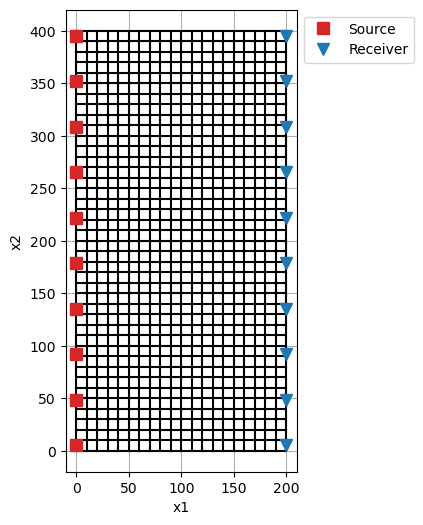

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

mesh.plot_grid(ax=ax, color="k")
ax.set_aspect(1)

ax.plot(source_locations[:, 0], source_locations[:, 1], "C3s", ms=8, label ='Source')
ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "C0v", ms=8, label = 'Receiver')
ax.legend(bbox_to_anchor=(1, 1))


## Question 1(a)

In [8]:
# Build the model

v0 = 1000
v1 = 400
block_x = np.r_[80, 120]
block_y = np.r_[170, 230]

base_model = v0*np.ones(mesh.n_cells)
background_velocity = base_model.copy()

In [9]:
def add_block(base_model, block_x, block_y, value): 
    inds_block = (
        (mesh.cell_centers[:, 0] > block_x.min()) &
        (mesh.cell_centers[:, 0] < block_x.max()) &
        (mesh.cell_centers[:, 1] > block_y.min()) &
        (mesh.cell_centers[:, 1] < block_y.max()) 
    ) 
    velocity_model = base_model.copy()
    velocity_model[inds_block] = value
    
    return velocity_model
    
velocity_model = add_block(base_model, block_x, block_y, v1) 

true_slowness_model = 1/velocity_model
background_slowness_model = 1/background_velocity

In [10]:
def plot_model_survey(
    mesh, model, source_locations, receiver_locations, ax=None, 
    show_raypaths=True, vmin=None, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    
    cb = plt.colorbar(
        mesh.plot_image(model, ax=ax, pcolor_opts={"vmin":vmin, "vmax":vmax})[0], 
        ax=ax
    )
    
    cb.set_label("velocity (m/s)")
    
    ax.set_aspect(1)

    ax.plot(source_locations[:, 0], source_locations[:, 1], "ws", ms=6)
    ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "wv", ms=6)
    
    if show_raypaths is True: 
        for i in range(source_locations.shape[0]):
            for j in range(receiver_locations.shape[0]):
                ax.plot(
                    np.r_[source_locations[i, 0], receiver_locations[j, 0]],
                    np.r_[source_locations[i, 1], receiver_locations[j, 1]],
                    color="k",
                    linewidth=0.5
                )
    return ax



<Axes: xlabel='x', ylabel='y'>

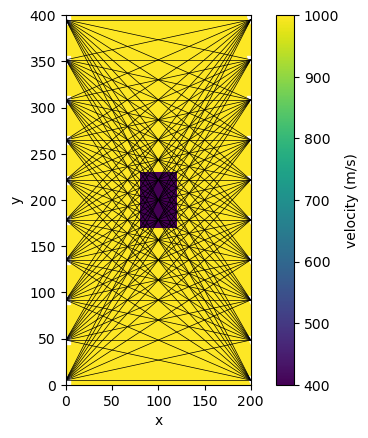

In [11]:
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=True
)

In [12]:
# Simulation

rx = survey.BaseRx(receiver_locations)


source_list = []

for i in range(y_src.size):
    source_list.append(
        survey.BaseSrc(
            location=source_locations[i, :], receiver_list=[rx]
        )
    )

In [13]:
tomo_survey = seismic.straight_ray_tomography.Survey(source_list)


In [14]:
simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)

In [15]:
background_data = simulation.dpred(background_slowness_model)
clean_data = simulation.dpred(true_slowness_model)

difference = clean_data - background_data
difference_in_percentage = (clean_data - background_data) / background_data


In [16]:
# Plotting data

levels = np.linspace(0.10, 0.60, 26)
contours = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]




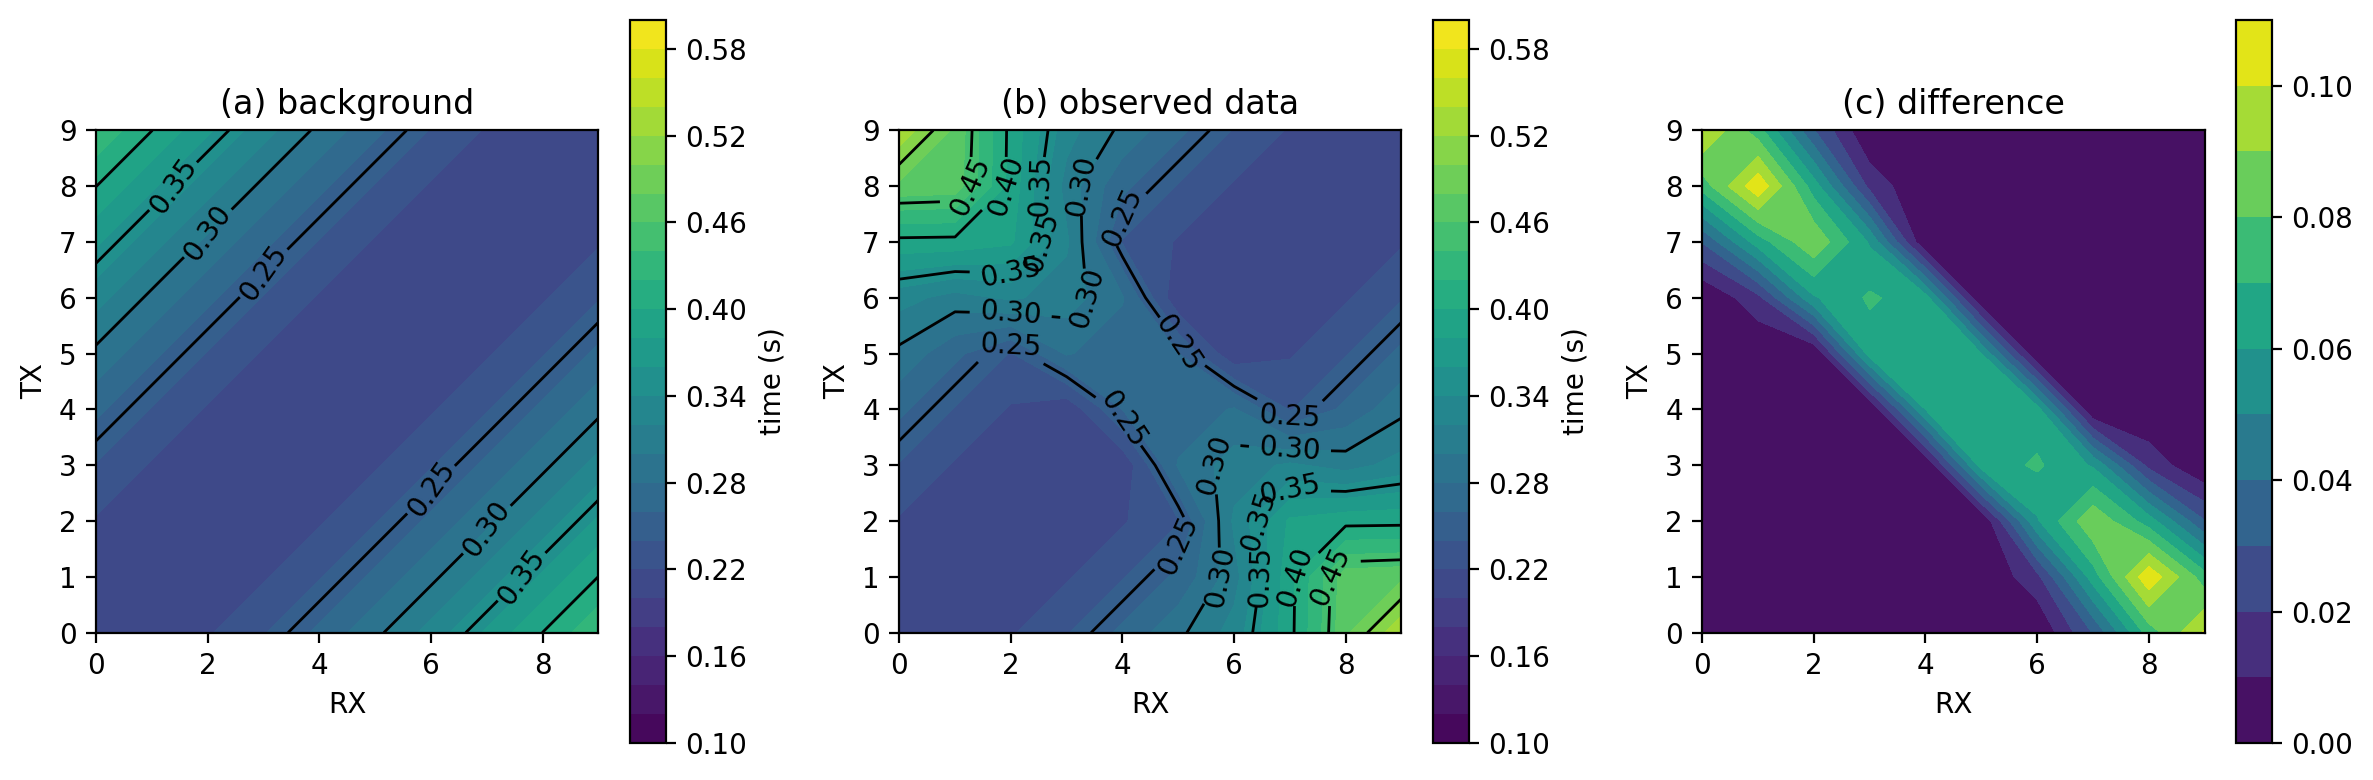

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=200)

for i, dplot in enumerate([background_data, clean_data]): 
    cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
    
    CS = ax[i].contour(
            dplot.reshape(n_src, n_src, order="F"), 
            levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
    )
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

plt.colorbar(ax[2].contourf(difference.reshape(n_src, n_src, order="F"),levels=10))
    

ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_aspect(1)

ax[2].set_xlabel("RX")
ax[2].set_ylabel("TX")
cb.set_label("time (s)")

ax[0].set_title("(a) background")
ax[1].set_title("(b) observed data")
ax[2].set_title("(c) difference")
plt.tight_layout()

## Question 1(b)

With a background of 1000m/s and a horizontal distance of 200m between the source and receiver, the corresponding travelling time should equal to 200 / 1000 = 0.2s.  By comparing with the values of the diagonal in the background data matrix (see the next cell), it can show whether the forward simulation is working properly.


In [18]:
background_data.reshape(n_src, n_src, order="F").diagonal()

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

## Question 1(c)

The difference of the two models can be obtained by subtracting the two data matrices.  The difference in percentage can be obtained by dividing the difference matrix by the background model.

In [19]:
print(f'Max difference between model with and without block = {difference.max():.2f}s')
print(f'Max difference between model with and without block = {difference_in_percentage.max()*100:.2f}%')

Max difference between model with and without block = 0.11s
Max difference between model with and without block = 30.00%


## Question 1(d)

In [501]:
relative_error=0.015
np.random.seed(7)

noisy_data = (
    clean_data + 
    np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
)

difference_noisy_data = noisy_data - background_data
difference_noisy_data_in_percentage = (noisy_data - background_data) / background_data

Relative error = 1.5%
Max difference between model with and without block = 0.11s
Max difference between model with and without block = 33.31%


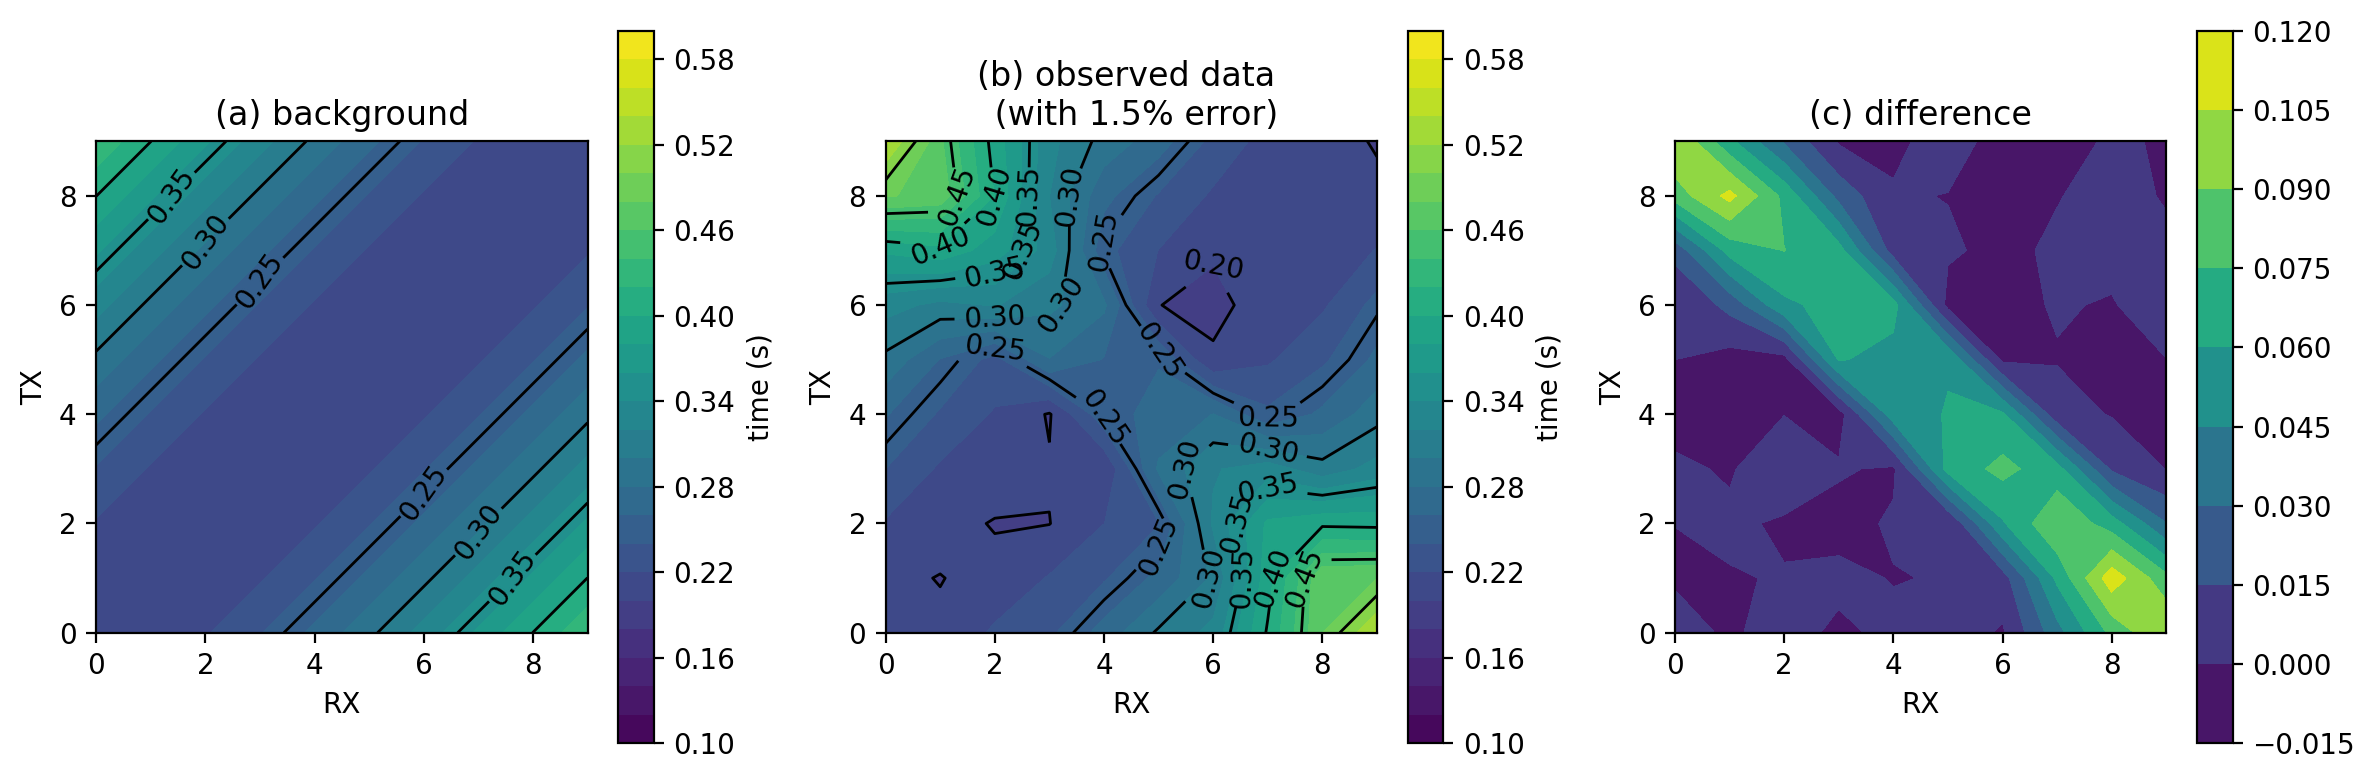

In [502]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=200)

for i, dplot in enumerate([background_data, noisy_data]): 
    cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
    
    CS = ax[i].contour(
            dplot.reshape(n_src, n_src, order="F"), 
            levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
    )
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

plt.colorbar(ax[2].contourf(difference_noisy_data.reshape(n_src, n_src, order="F"),levels=10))
    
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_aspect(1)

ax[2].set_xlabel("RX")
ax[2].set_ylabel("TX")
cb.set_label("time (s)")

ax[0].set_title("(a) background")
ax[1].set_title(f'(b) observed data \n (with {np.round(relative_error*100,1)}% error)')
ax[2].set_title("(c) difference")
plt.tight_layout()
print(f'Relative error = {relative_error*100:.1f}%')
print(f'Max difference between model with and without block = {difference_noisy_data.max():.2f}s')
print(f'Max difference between model with and without block = {difference_noisy_data_in_percentage.max()*100:.2f}%')

## Ans:
The following plots show the observed data with different percentage noise levels. 
With no noise, the max difference between model with and without block is 30%.
With 5% relative noise, the max diffference is increased to 41%.  On the other hand, more obvious structures with negative difference were also introduced into the data. This poses a difficulty in correctly identifying the target.

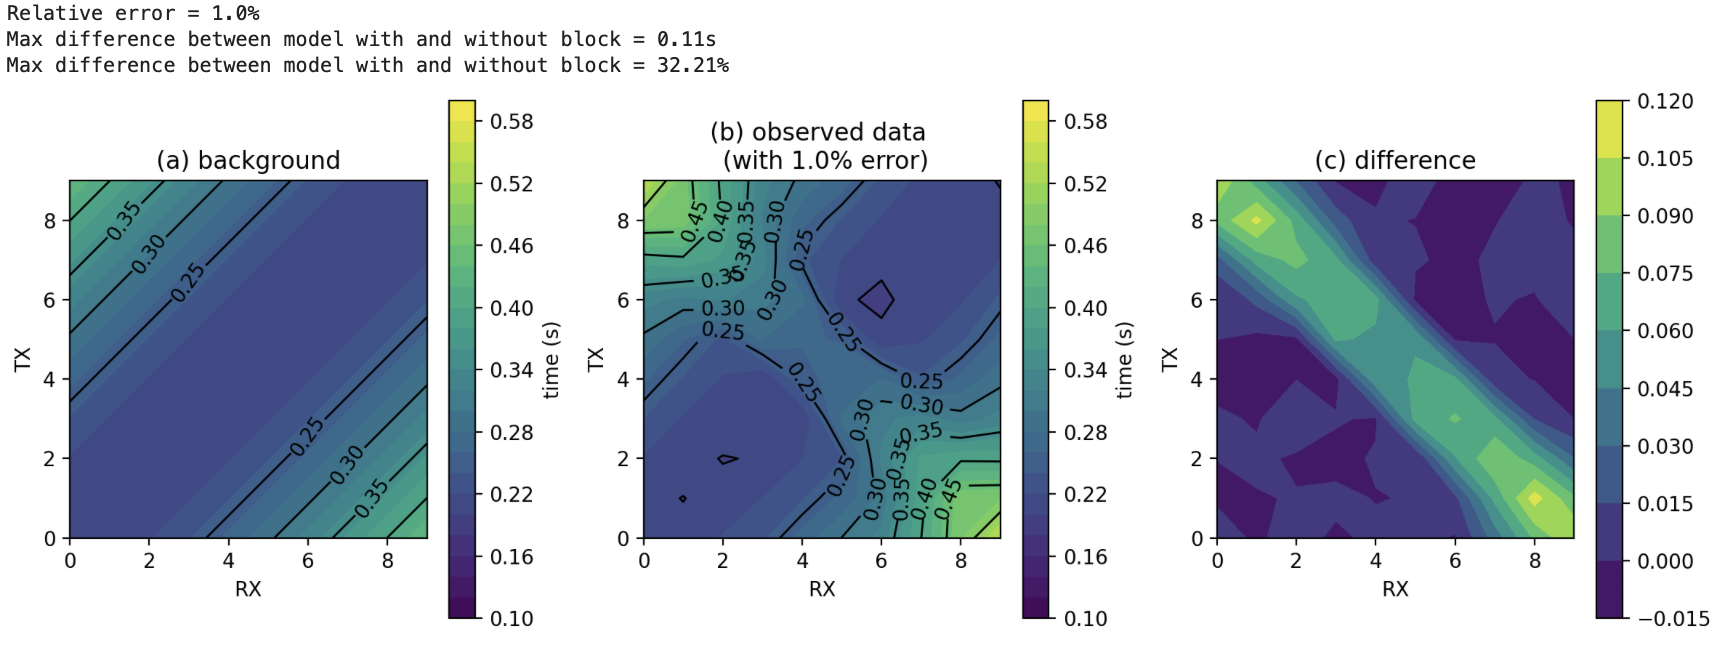
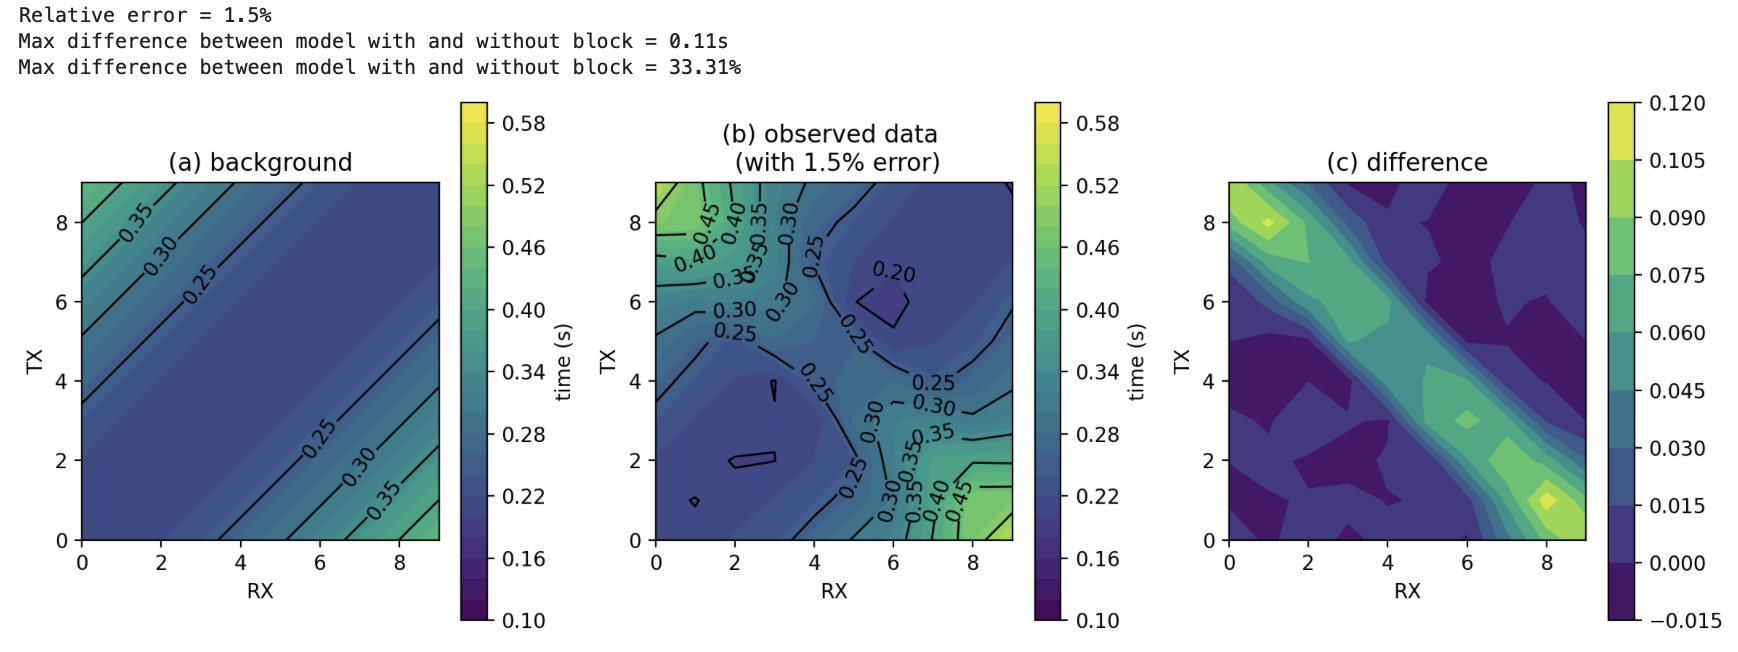
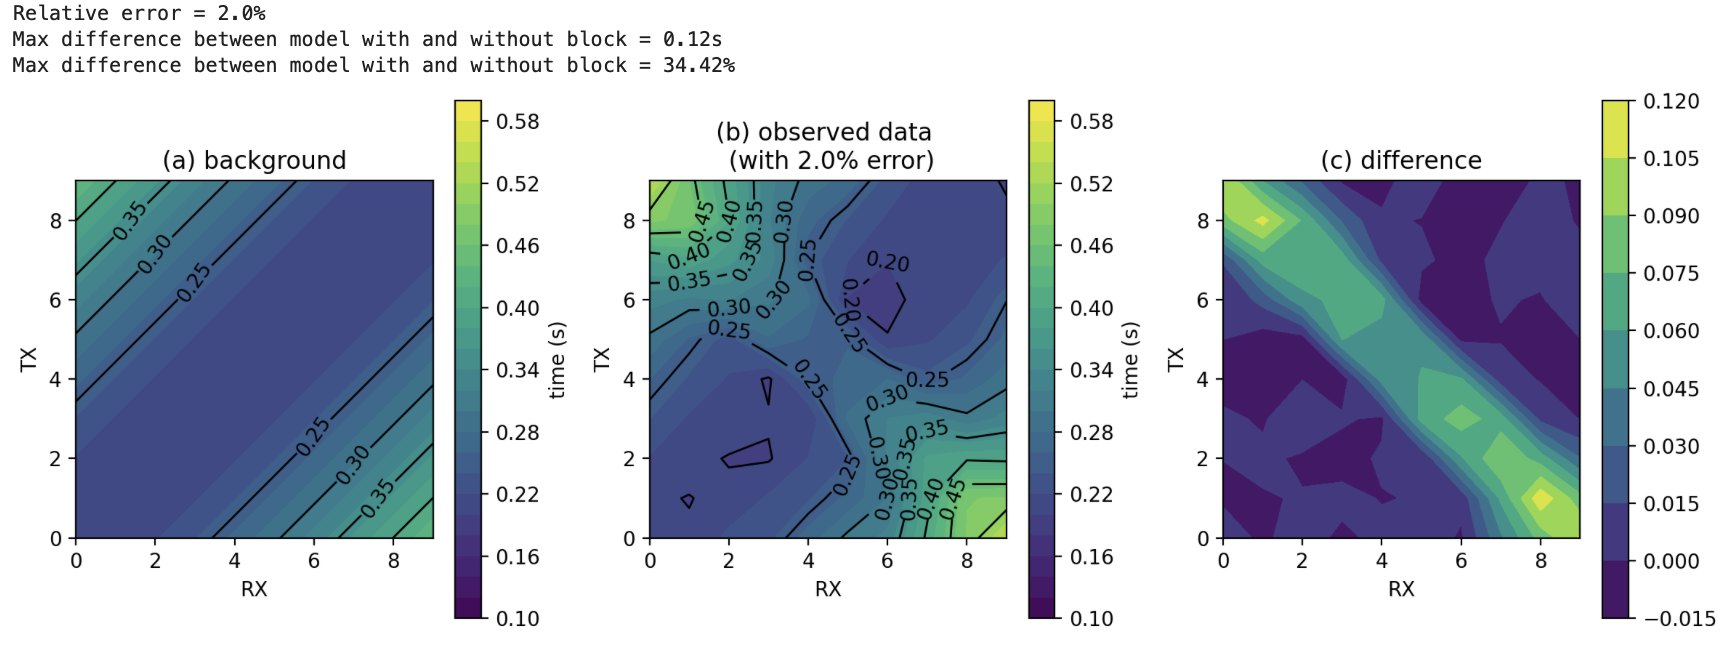
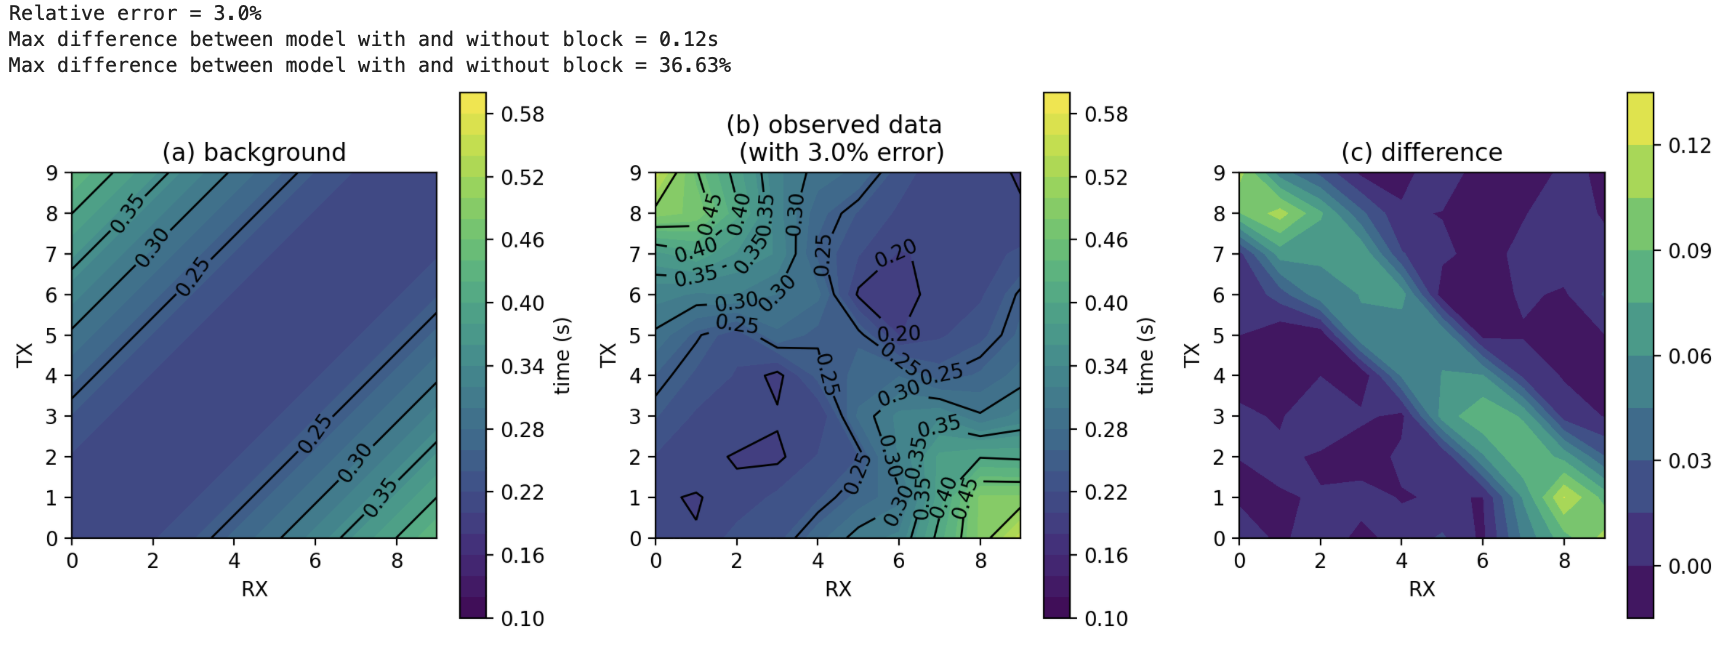
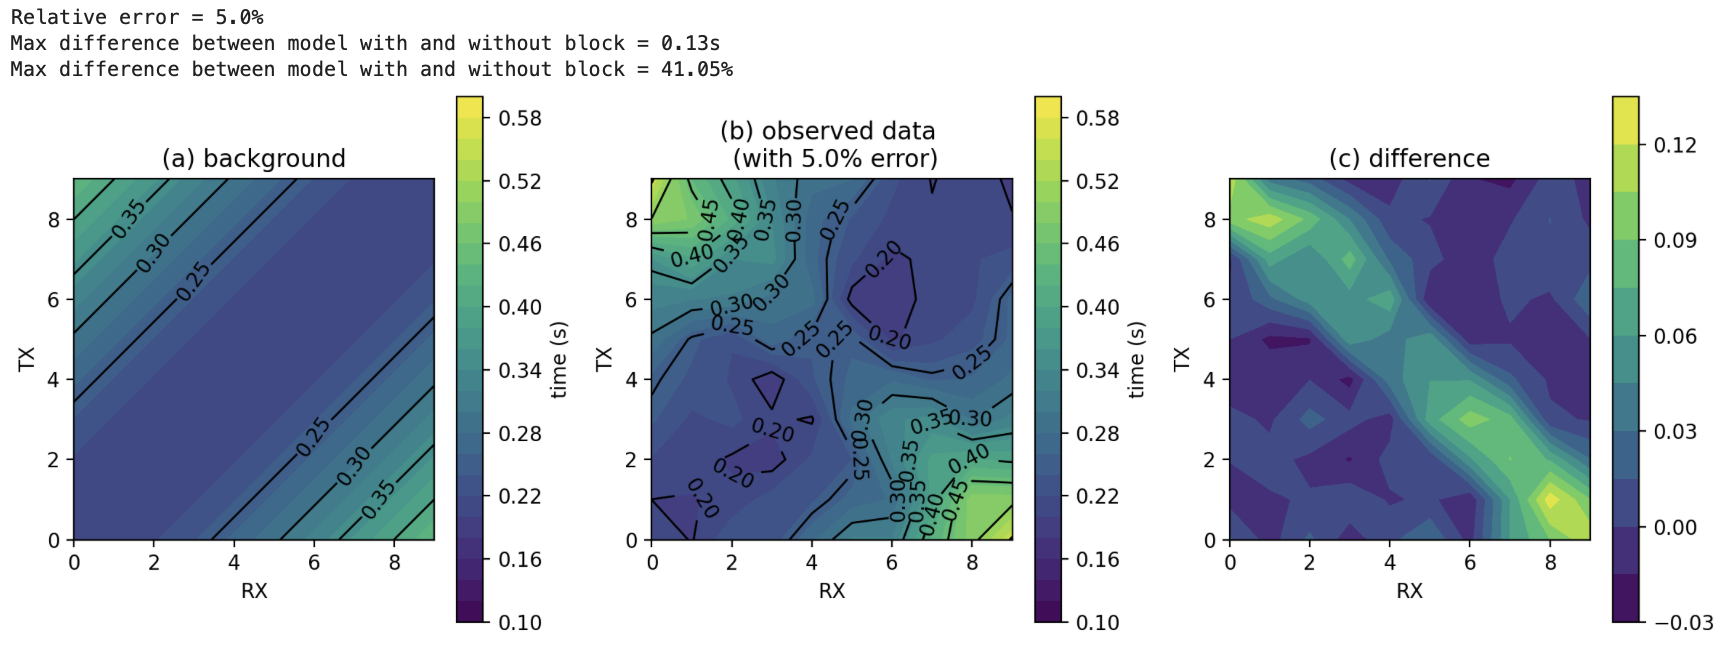

## Question 1(e)

<Axes: xlabel='x', ylabel='y'>

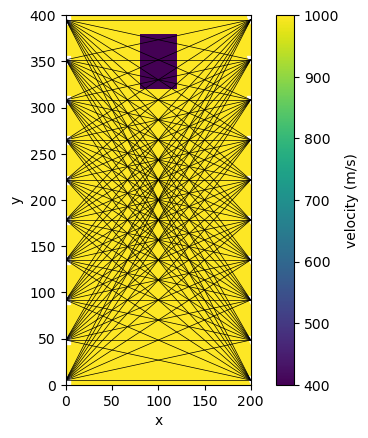

In [22]:
block_x = np.r_[80, 120]
block_y_top = np.r_[320, 380]

velocity_model_block_top = add_block(base_model, block_x, block_y_top, v1) 
true_slowness_model_block_top = 1/velocity_model_block_top


plot_model_survey(
    mesh, velocity_model_block_top, source_locations, receiver_locations,
    show_raypaths=True
)

In [301]:
clean_data_block_top = simulation.dpred(true_slowness_model_block_top)

relative_error=0.00
np.random.seed(7)

noisy_data_block_top = (
    clean_data_block_top + 
    np.random.randn(len(clean_data_block_top)) * relative_error * np.abs(clean_data_block_top)
)

difference_noisy_data_block_top = noisy_data_block_top - background_data
difference_noisy_data_block_top_in_percentage = (noisy_data_block_top - background_data) / background_data

Relative error = 0.0%
Max difference between model with and without block = 0.07s
Max difference between model with and without block = 30.00%


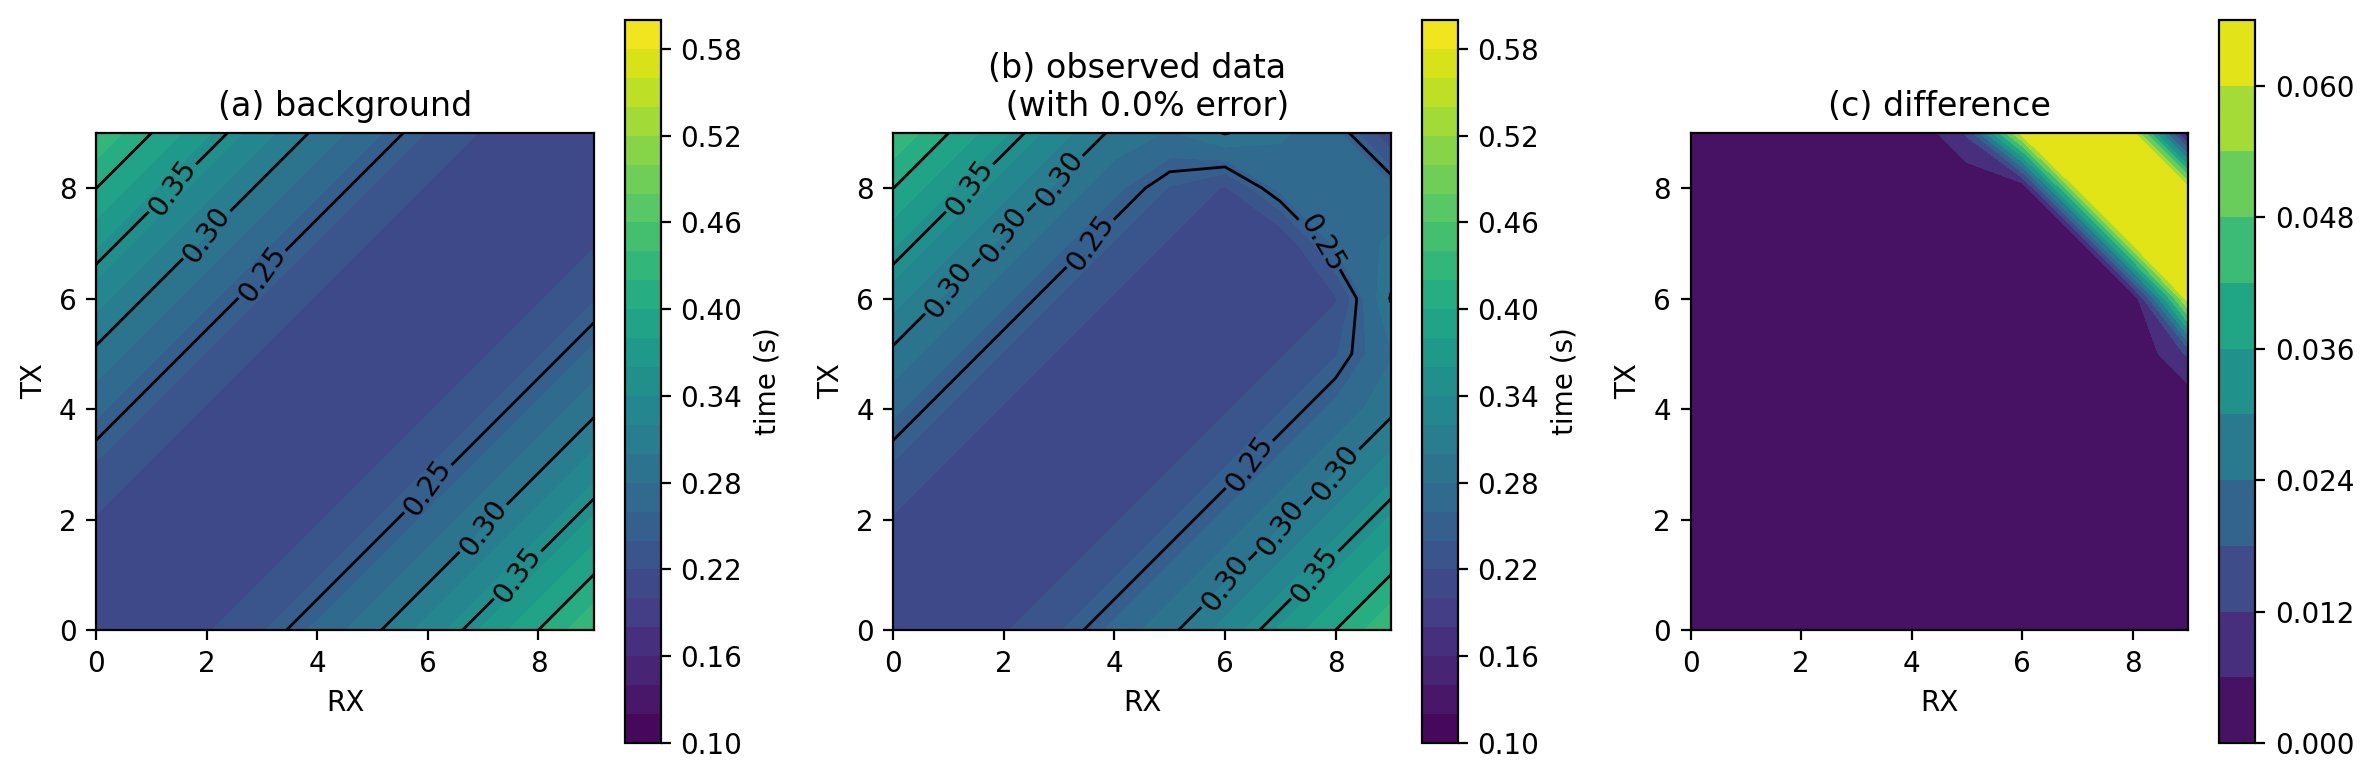

In [302]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=200)

for i, dplot in enumerate([background_data, noisy_data_block_top]): 
    cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
    
    CS = ax[i].contour(
            dplot.reshape(n_src, n_src, order="F"), 
            levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
    )
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

plt.colorbar(ax[2].contourf(difference_noisy_data_block_top.reshape(n_src, n_src, order="F"),levels=10))
    

ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_aspect(1)

ax[2].set_xlabel("RX")
ax[2].set_ylabel("TX")
cb.set_label("time (s)")

ax[0].set_title("(a) background")
ax[1].set_title(f'(b) observed data \n (with {np.round(relative_error*100,1)}% error)')
ax[2].set_title("(c) difference")
plt.tight_layout()

print(f'Relative error = {relative_error*100:.1f}%')
print(f'Max difference between model with and without block = {difference_noisy_data_block_top.max():.2f}s')
print(f'Max difference between model with and without block = {difference_noisy_data_block_top_in_percentage.max()*100:.2f}%')

## Ans:
The following plots show the observed data with different percentage noise levels. As the target is covered by less raypaths, it is harder to identify the target. At 3% noise level, the target is mixed with other structures due to the noise.

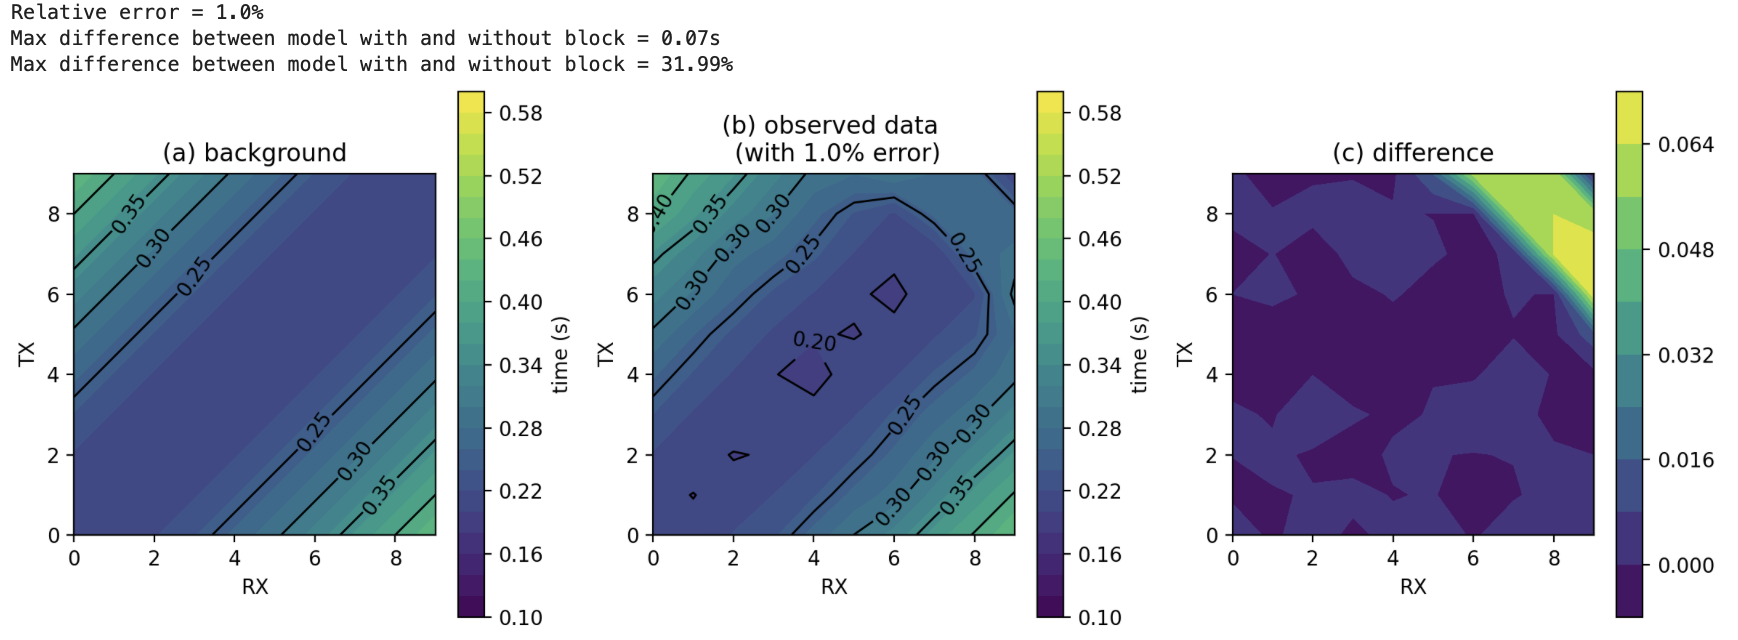
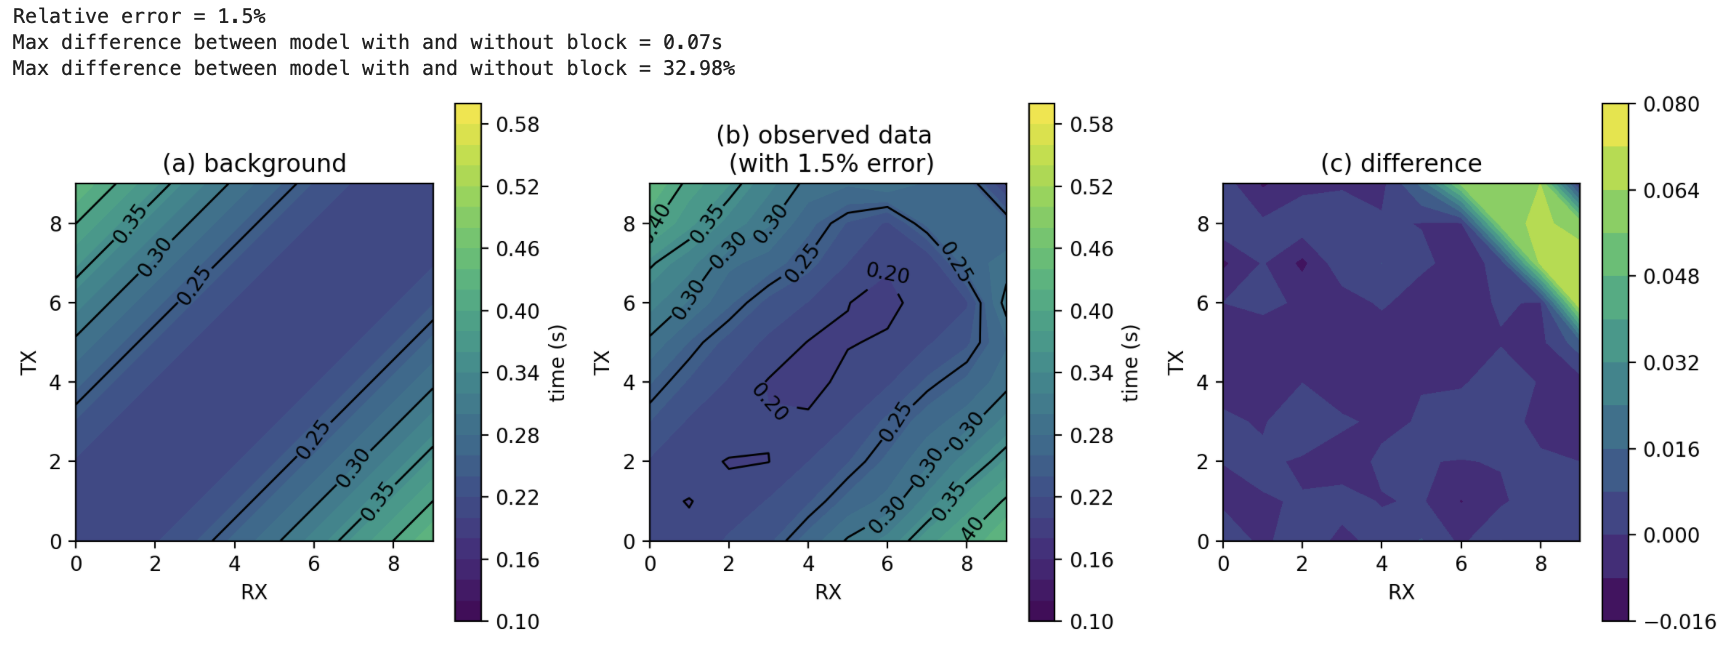
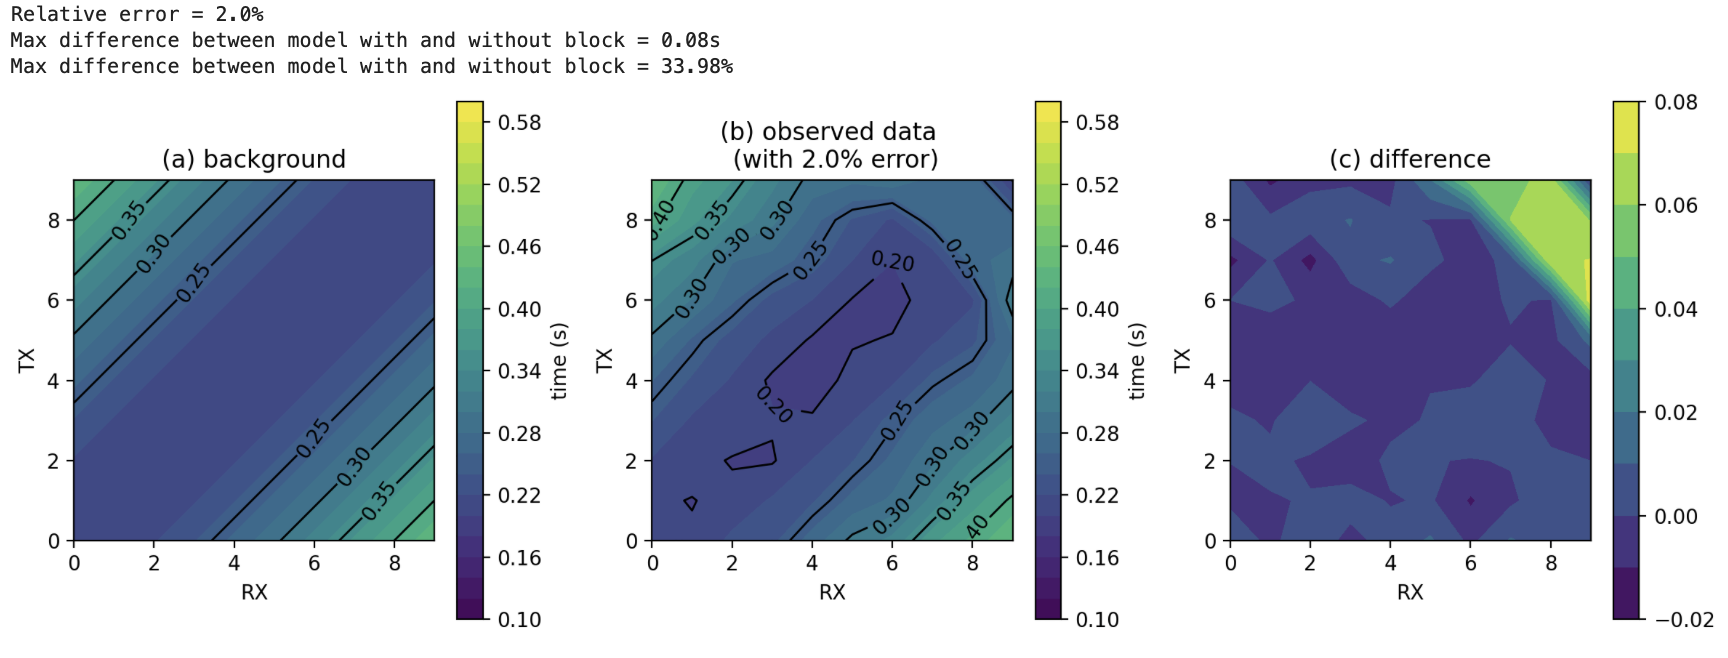
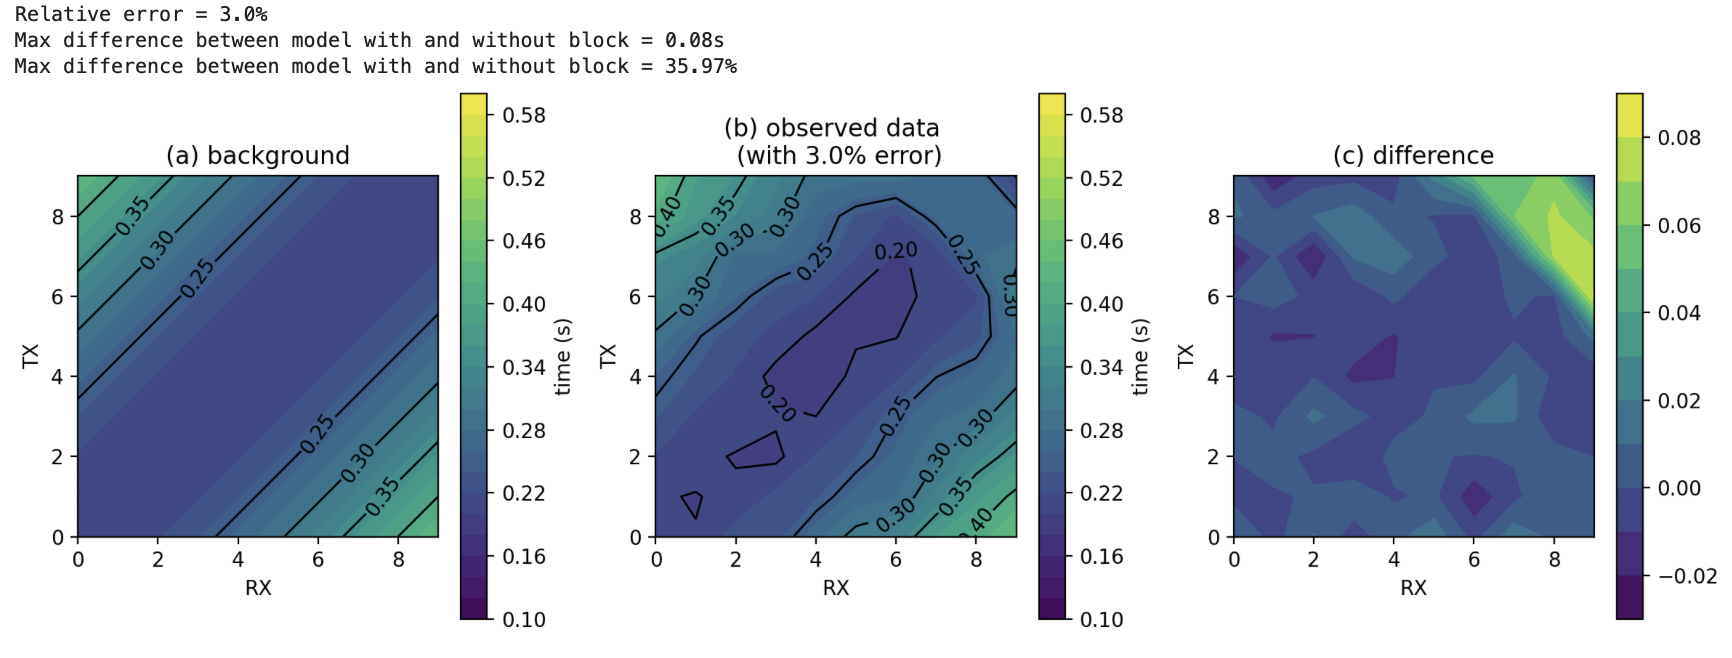
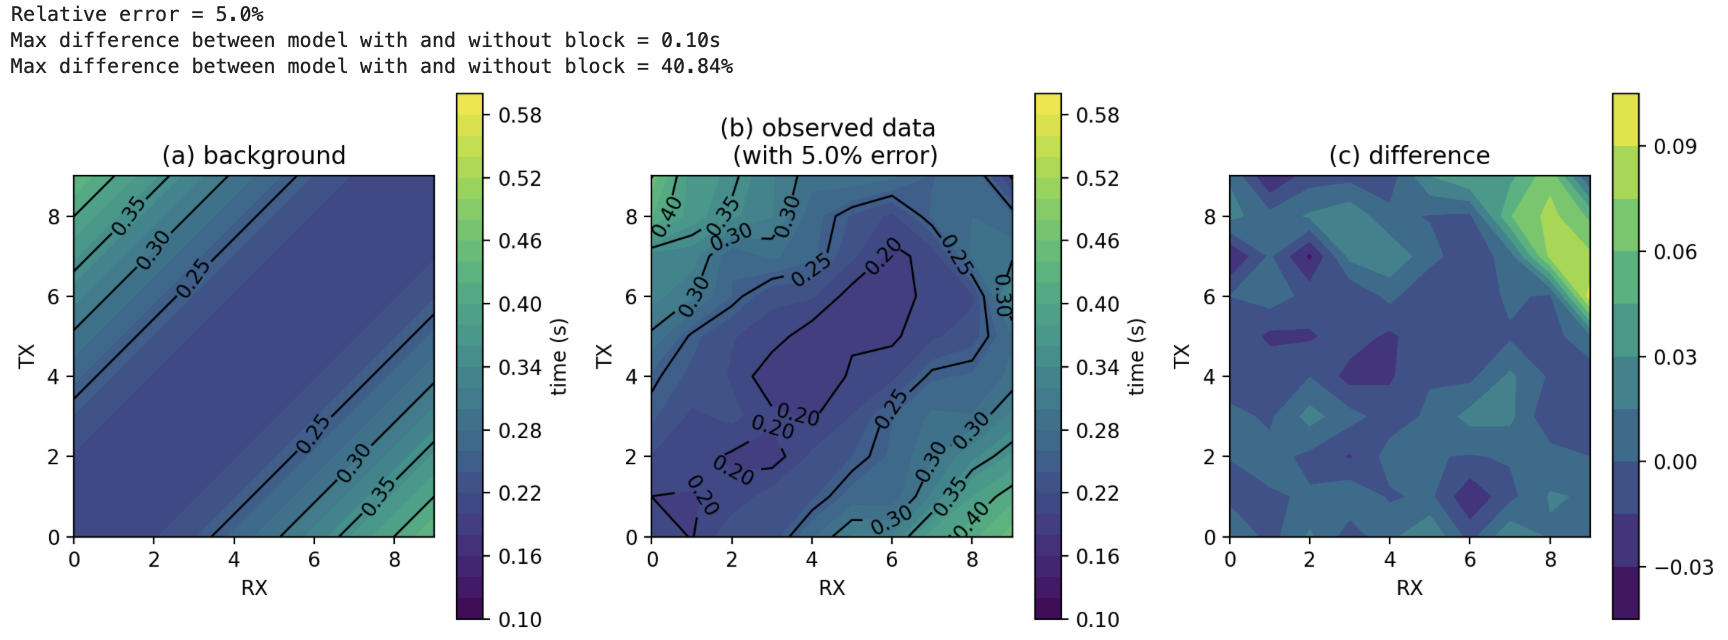

## Question 2(a)

Noise level at 2% is chosen for the data for the inversion.  To set up a "smoothest" model, alpha_s is set to a relatively small value (1e-6) while alpha_x and alpha_y to 1.  An iteration with phi_d close to the target misfit (=100) is picked.  The residual (i.e. predicted data - observed data) is in the order of 0.04s which is about 8% of the data value.

In [516]:
relative_error=0.02
np.random.seed(7)

data_for_inversion = (
    clean_data + 
    np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
)


In [517]:
data_object = data.Data(tomo_survey, dobs=data_for_inversion, relative_error=relative_error)

In [505]:
dmis = data_misfit.L2DataMisfit(data_object, simulation)

In [506]:
alpha_s = 1e-6 
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [507]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [508]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [509]:
inv = inversion.BaseInversion(invprob, directives_list)

In [510]:
m0 = background_slowness_model
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.20e+09  1.51e+03  0.00e+00  1.51e+03    7.03e+05      0              
   1  4.16e+09  8.99e+02  2.02e-08  9.83e+02    6.84e+04      0              
   2  3.33e+09  8.66e+02  2.73e-08  9.57e+02    6.62e+04      0   Skip BFGS  
   3  2.66e+09  8.31e+02  3.66e-08  9.29e+02    6.40e+04      0   Skip BFGS  
   4  2.13e+09  7.95e+02  4.89e-08  8.99e+02    6.18e+04      0   Skip BFGS  
   5  1.7

In [511]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")
        ax[2].plot(phi_m, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_m[iteration], phi_d[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

In [512]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

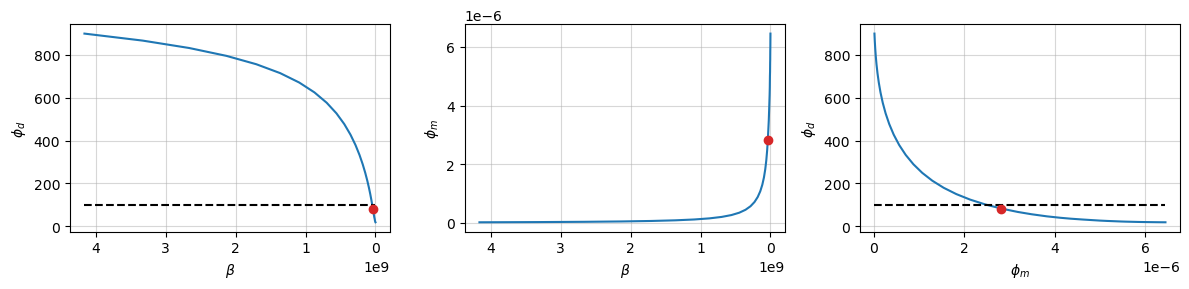

In [513]:
iteration = 21
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

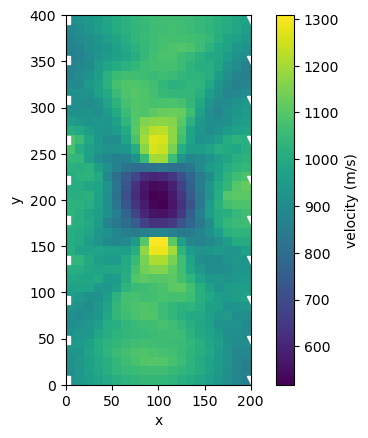

In [514]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

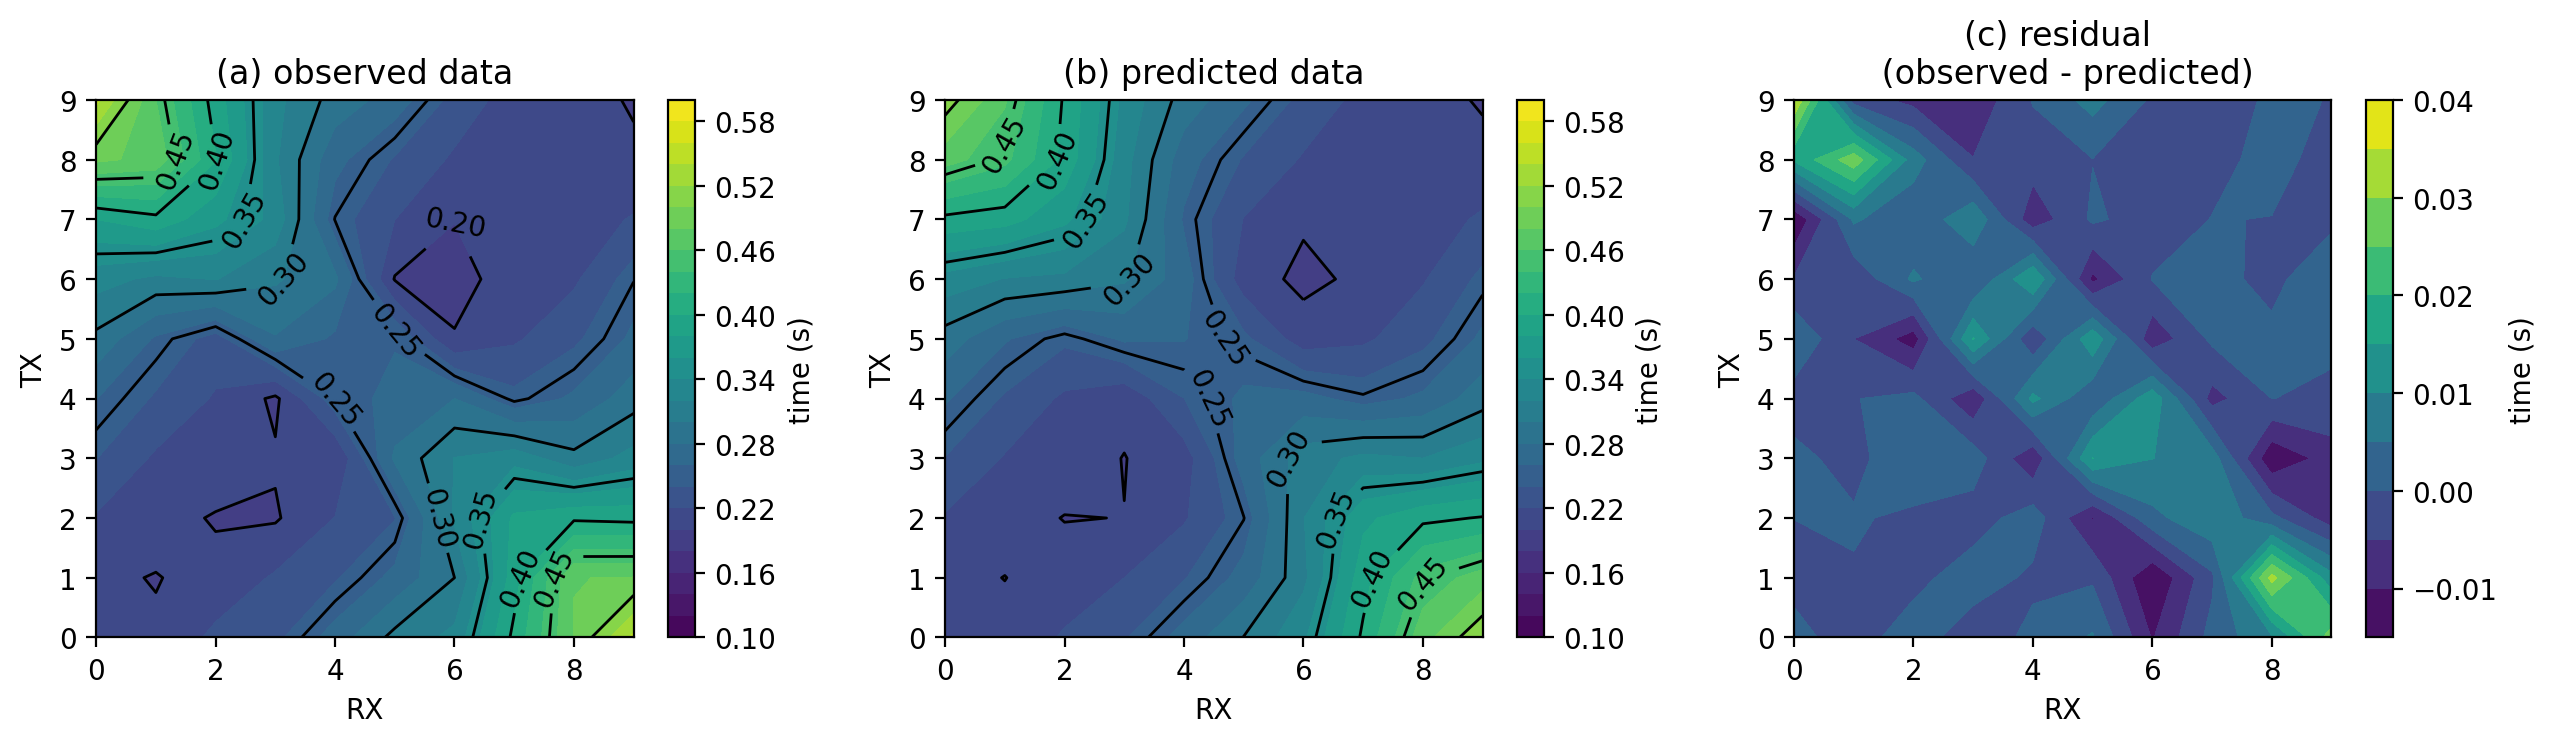

In [515]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Question 2(b)


In [518]:
data_object_large_error = data.Data(tomo_survey, dobs=data_for_inversion, relative_error=relative_error*2)

In [519]:
dmis_large_error = data_misfit.L2DataMisfit(data_object_large_error, simulation)

In [520]:
alpha_s = 1e-6 
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [521]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis_large_error, reg, opt)

In [522]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [523]:
inv = inversion.BaseInversion(invprob, directives_list)

In [524]:
m0 = background_slowness_model
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.30e+09  3.78e+02  0.00e+00  3.78e+02    1.76e+05      0              
   1  1.04e+09  2.25e+02  2.02e-08  2.46e+02    1.71e+04      0              
   2  8.32e+08  2.16e+02  2.73e-08  2.39e+02    1.65e+04      0   Skip BFGS  
   3  6.66e+08  2.08e+02  3.66e-08  2.32e+02    1.60e+04      0   Skip BFGS  
   4  5.33e+08  1.99e+02  4.89e-08  2.25e+02    1.55e+04      0   Skip BFGS  
   5  4.2

In [525]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

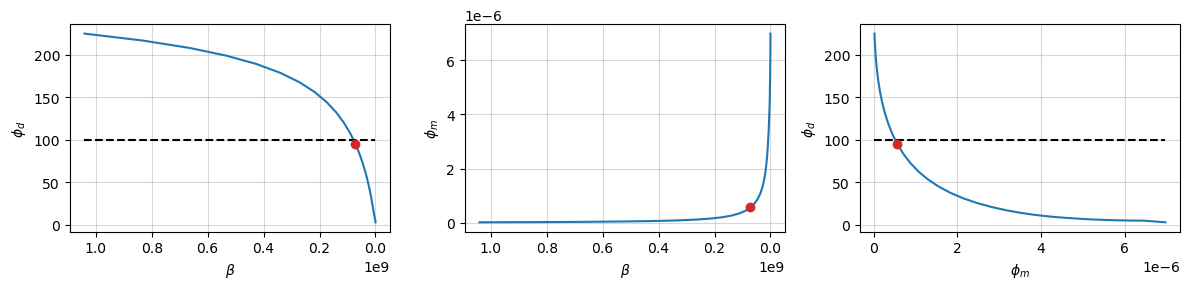

In [526]:
iteration = 12
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

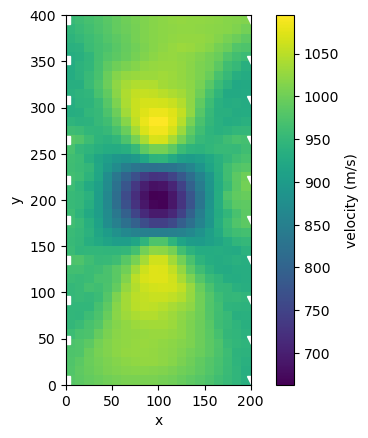

In [527]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

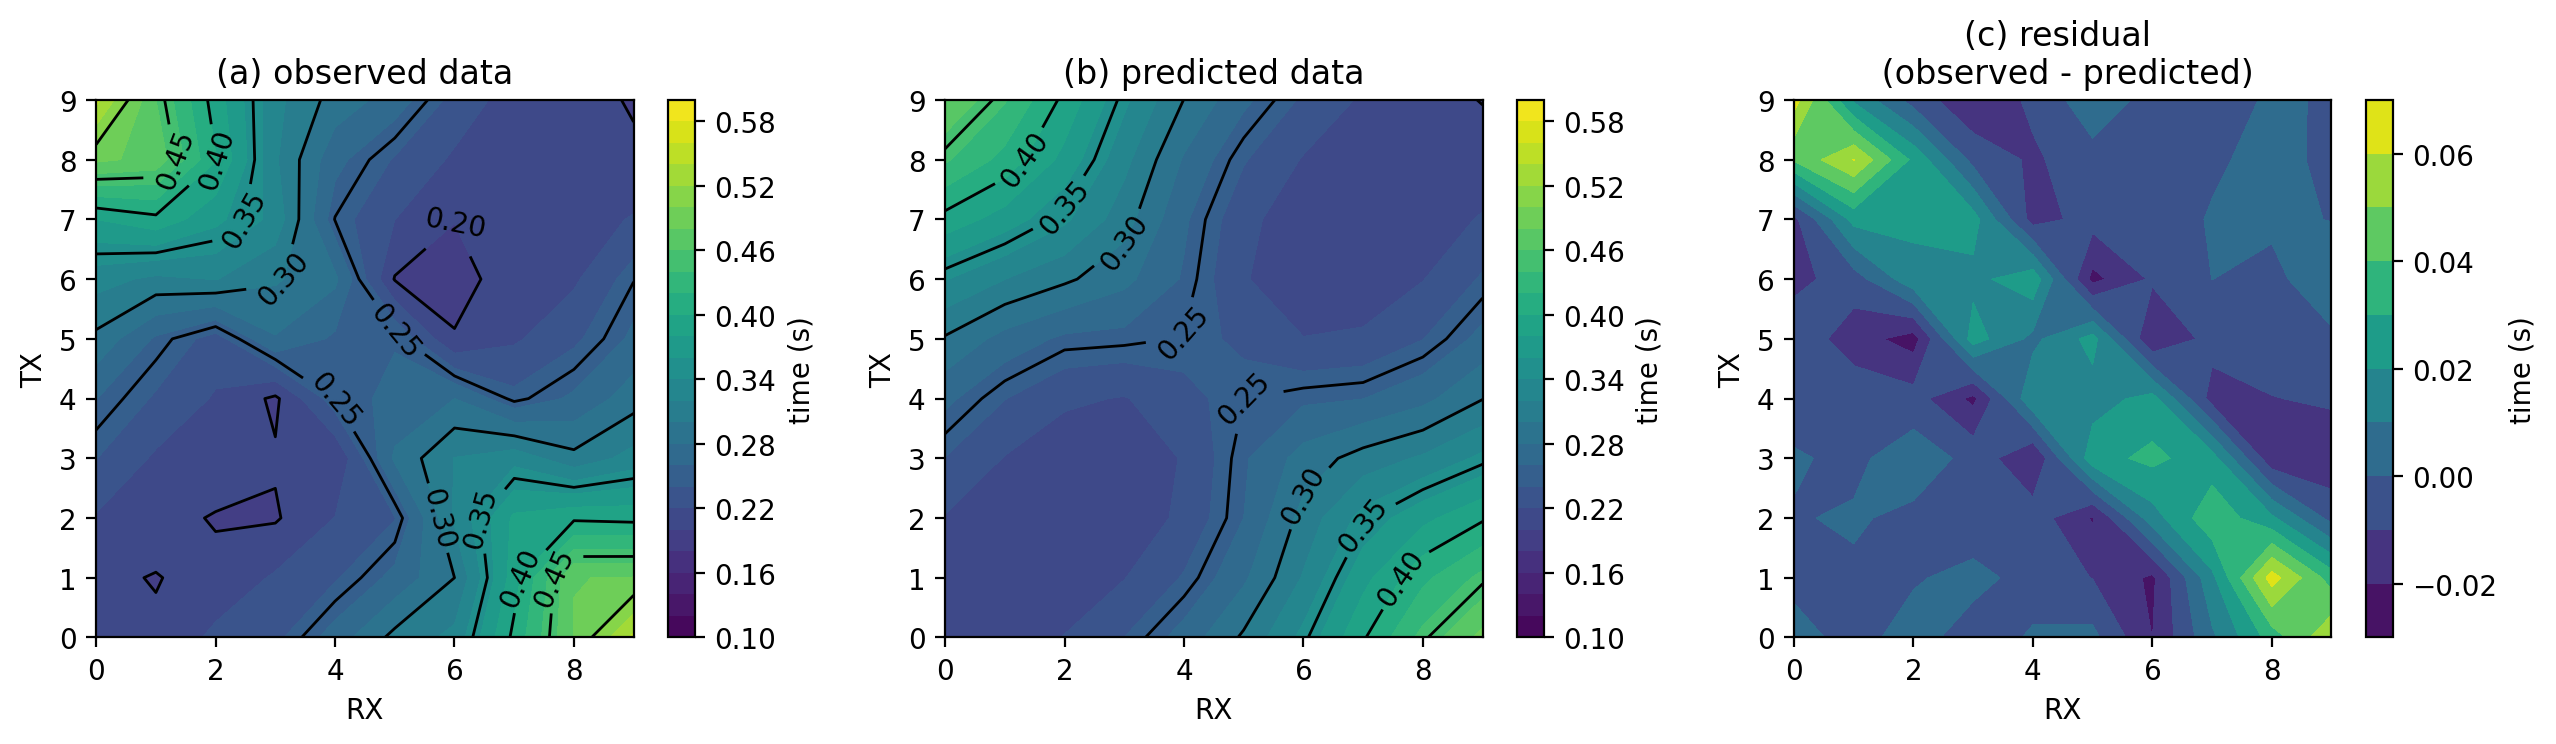

In [528]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

The inversion was carried out with the relative error set to double in the "data object" while all other parameters stay the same.  It can be seen that the target misfit lies above the elbow of the Tikhonov curve.  The target in the predicted model is further away from the true value.  The residual in the predicted data is much higher (in the order of 0.07s).  These all suggest that we are underfitting the data.  In order to obtain a better result, the Chi-factor should be set to a value of larger than 1, such that iteration with a lower value of phi_d can be computed.


## Question 2(c)


In [529]:
data_object_small_error = data.Data(tomo_survey, dobs=data_for_inversion, relative_error=relative_error*0.1)

In [530]:
dmis_small_error = data_misfit.L2DataMisfit(data_object_small_error, simulation)

In [531]:
alpha_s = 1e-6 
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [538]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=60)

invprob = inverse_problem.BaseInvProblem(dmis_small_error, reg, opt)

In [539]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [540]:
inv = inversion.BaseInversion(invprob, directives_list)

In [541]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.37e+11  1.51e+05  0.00e+00  1.51e+05    7.03e+07      0              
   1  4.30e+11  9.03e+04  1.94e-08  9.86e+04    6.86e+06      0              
   2  3.44e+11  8.71e+04  2.61e-08  9.61e+04    6.65e+06      0   Skip BFGS  
   3  2.75e+11  8.37e+04  3.51e-08  9.33e+04    6.43e+06      0   Skip BFGS  
   4  2.20e+11  8.00e+04  4.69e-08  9.03e+04    6.21e+06      0   Skip BFGS  
   5  1.76e+11  7.62e+04  6.27e-08  8.72e+04    5.99e+06      0   Skip BFGS  
   6  1.41e+11  7.21e+04  8.36e-08  8.38e+04    5.76e+06     

In [542]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

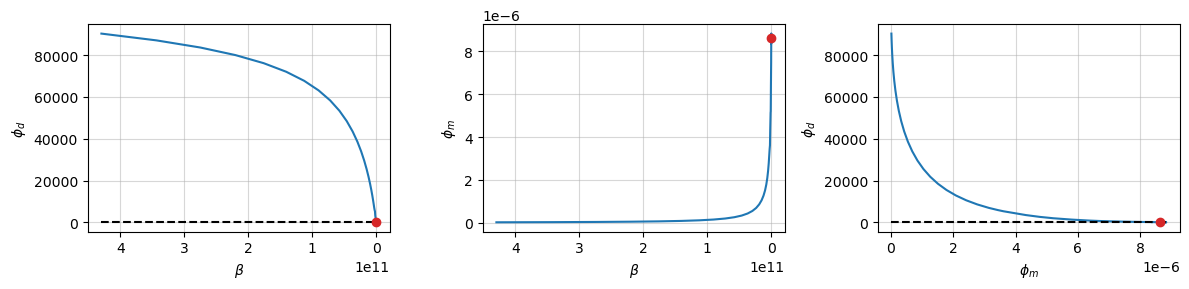

In [543]:
iteration = 45
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

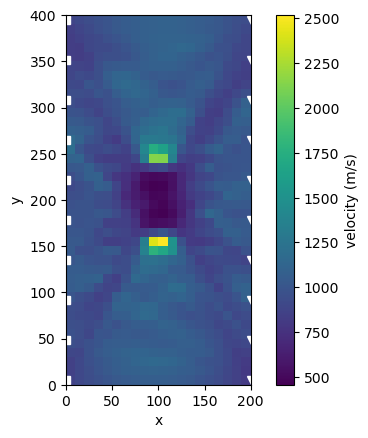

In [544]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

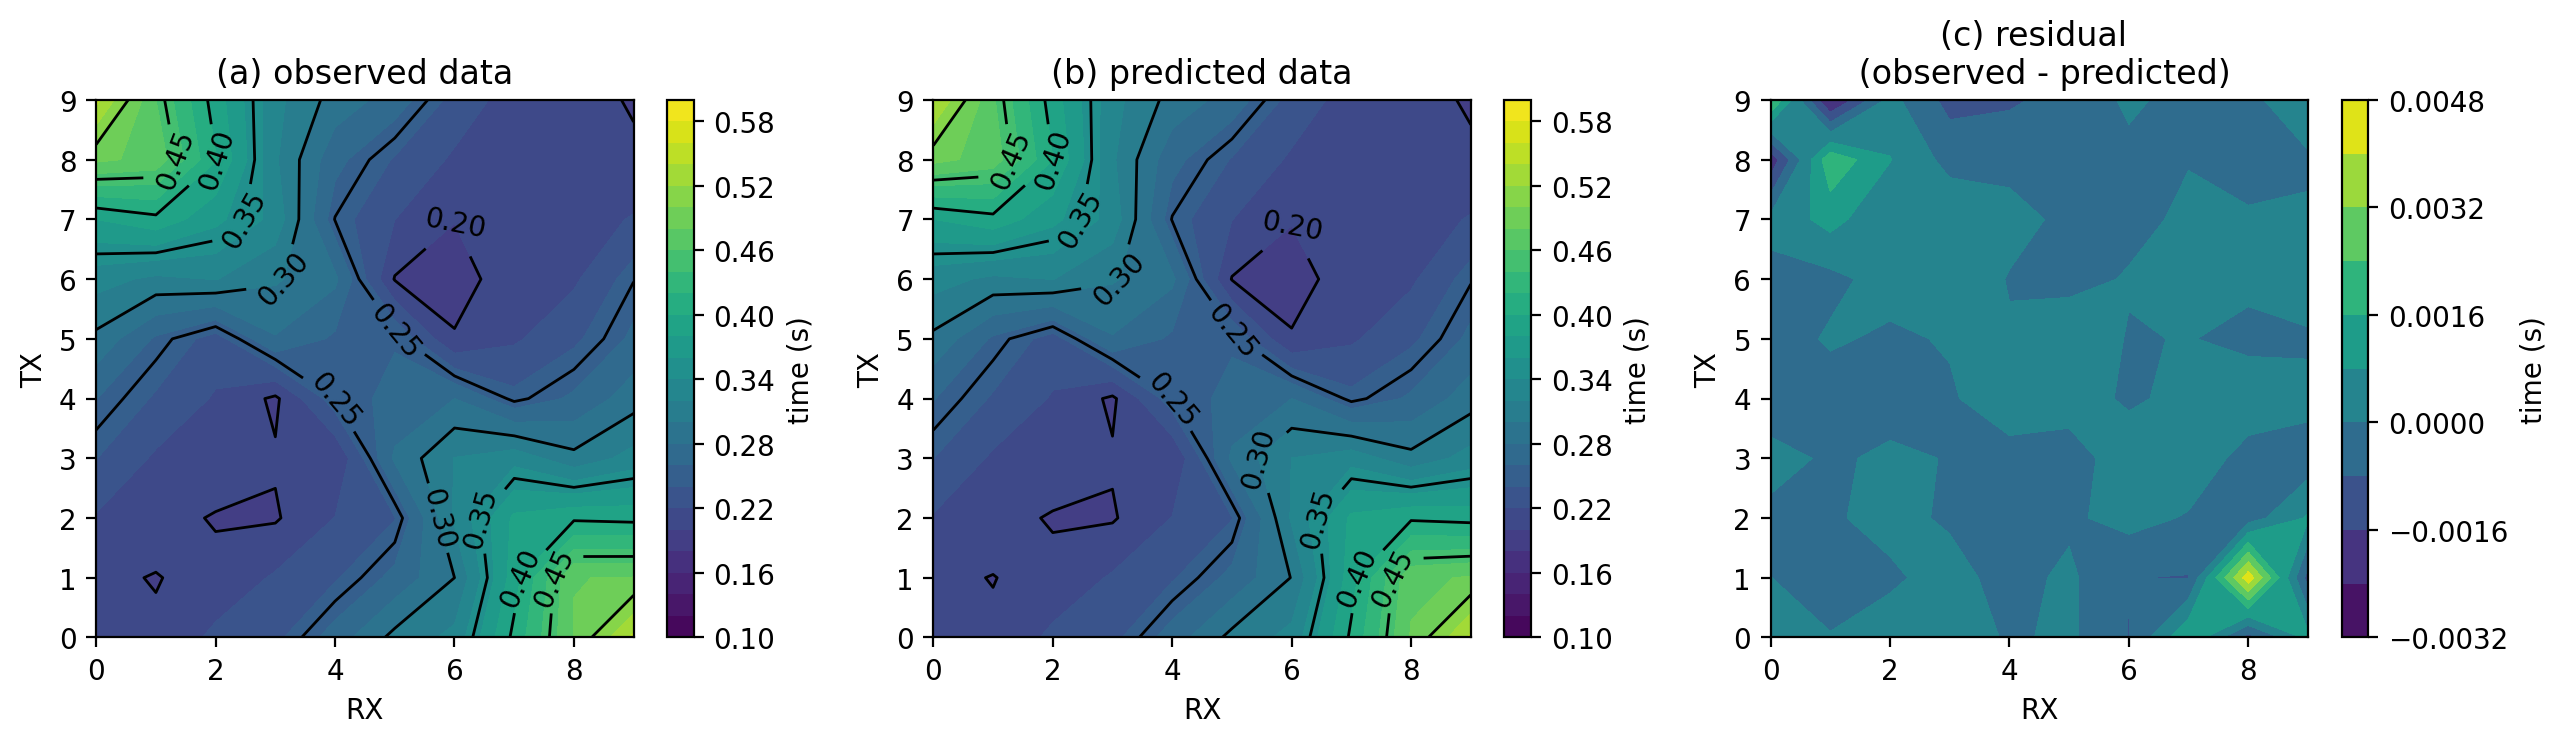

In [545]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

The inversion was carried out with the relative error set to 10% of the true error in the "data object" while all other parameters stay the same, except with more iterations.  It can be seen that the target misfit lies way below the elbow of the Tikhonov curve.  Although the target in the predicted model is close to the true value, other noisy structures (zones with extremely high velocity) are present in the model.  The residual in the predicted data is very small (in the order of 0.005s).  These all suggest that we are overfitting the data.  

Data seems to be overfitted when the iteration has passed below the elbow of the Tikhonov curve.

## Question 3(a)

The inversion is performed again with alpha_s set to 0.01 (which is inverse square of the length scale).

In [546]:
data_object = data.Data(tomo_survey, dobs=data_for_inversion, relative_error=relative_error)

In [547]:
dmis = data_misfit.L2DataMisfit(data_object, simulation)

In [548]:
alpha_s2 = 1/mesh.h[0][0]**2
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg2 = alpha_s2 * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [549]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis, reg2, opt)

In [550]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [551]:
inv = inversion.BaseInversion(invprob, directives_list)

In [552]:
m0 = background_slowness_model
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.62e+09  1.51e+03  0.00e+00  1.51e+03    7.03e+05      0              
   1  3.70e+09  1.43e+03  8.66e-09  1.46e+03    1.35e+05      0              
   2  2.96e+09  1.41e+03  1.32e-08  1.45e+03    1.33e+05      0   Skip BFGS  
   3  2.37e+09  1.39e+03  2.01e-08  1.44e+03    1.31e+05      0   Skip BFGS  
   4  1.89e+09  1.36e+03  3.03e-08  1.42e+03    1.29e+05      0   Skip BFGS  
   5  1.5

In [553]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

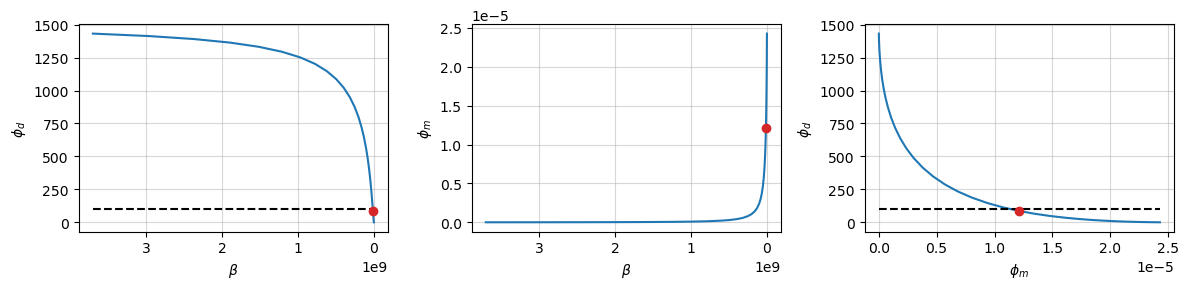

In [554]:
iteration = 25
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

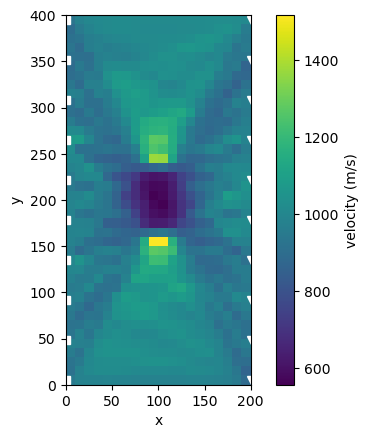

In [555]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

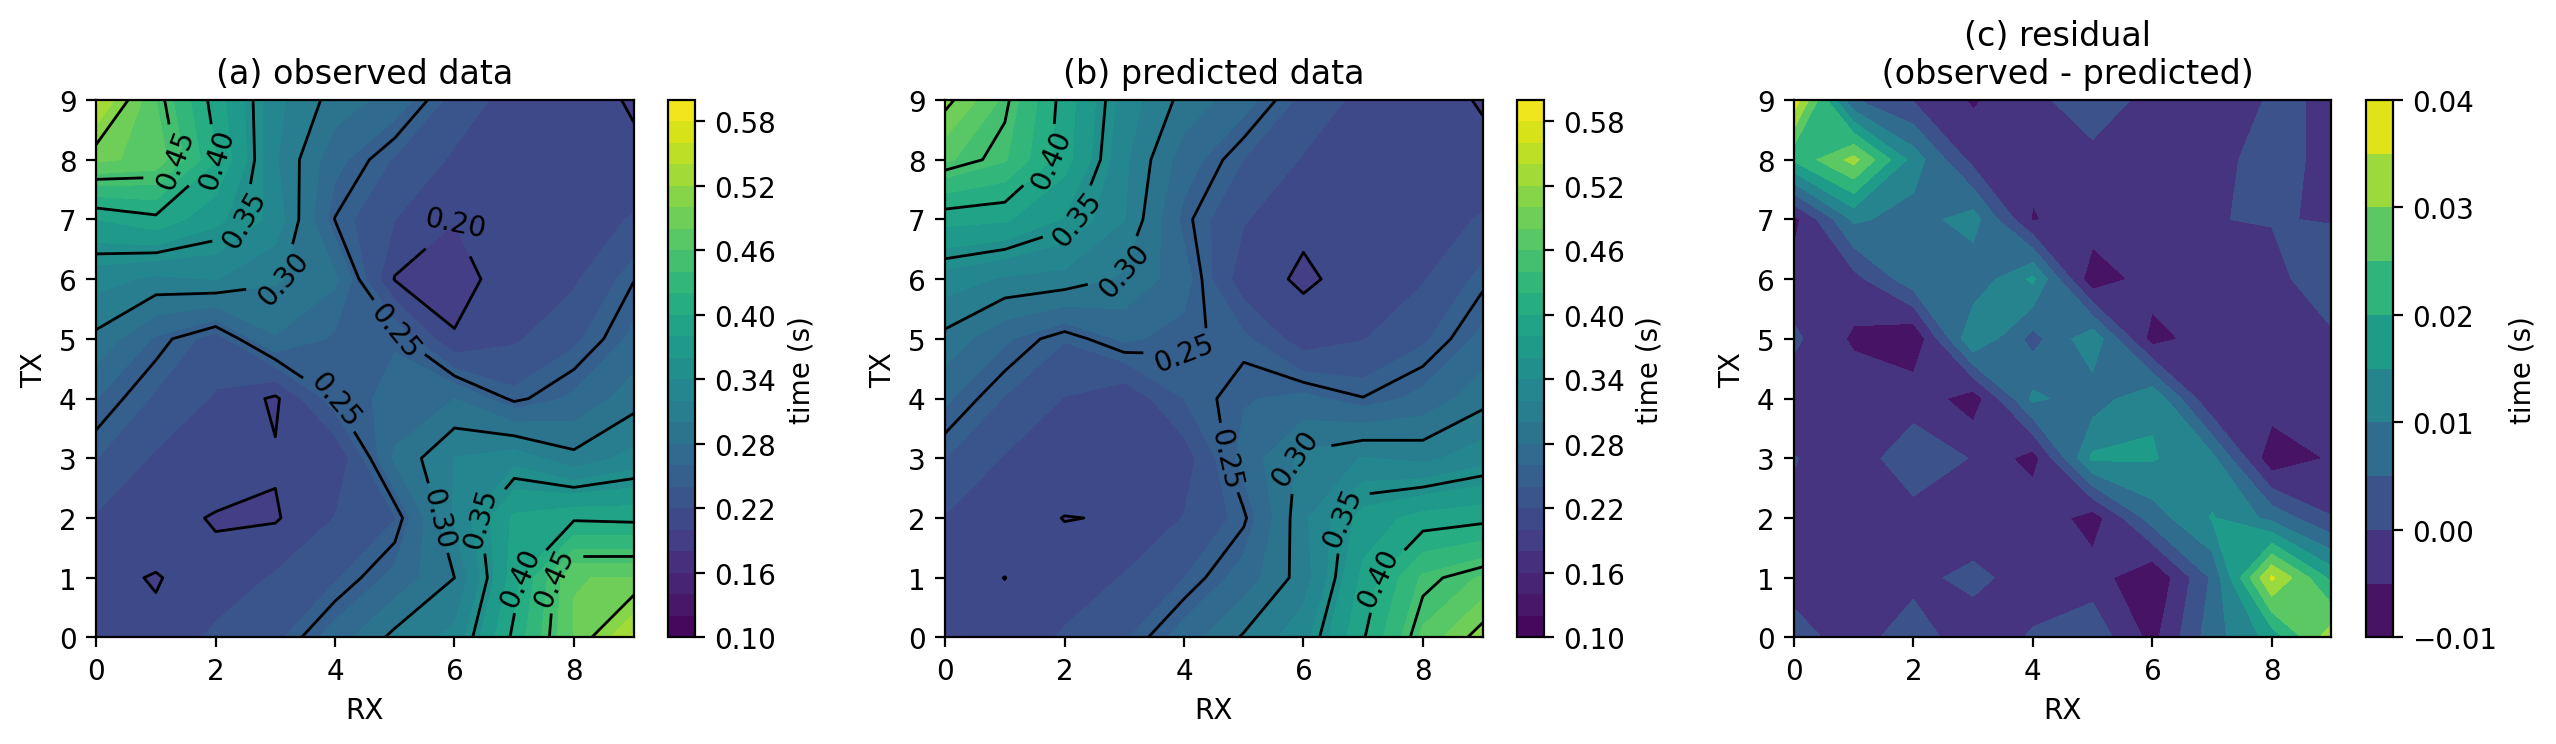

In [556]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Question 3(b)


### Balanced alpha-values, overestimating the noise

In [557]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis_large_error, reg2, opt)

In [558]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [559]:
inv = inversion.BaseInversion(invprob, directives_list)

In [560]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.15e+09  3.78e+02  0.00e+00  3.78e+02    1.76e+05      0              
   1  9.22e+08  3.58e+02  8.71e-09  3.66e+02    3.36e+04      0              
   2  7.38e+08  3.53e+02  1.33e-08  3.63e+02    3.33e+04      0   Skip BFGS  
   3  5.90e+08  3.47e+02  2.02e-08  3.59e+02    3.28e+04      0   Skip BFGS  
   4  4.72e+08  3.41e+02  3.05e-08  3.55e+02    3.23e+04      0   Skip BFGS  
   5  3.78e+08  3.33e+02  4.57e-08  3.50e+02    3.17e+04      0   Skip BFGS  
   6  3.02e+08  3.23e+02  6.79e-08  3.44e+02    3.10e+04     

In [561]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

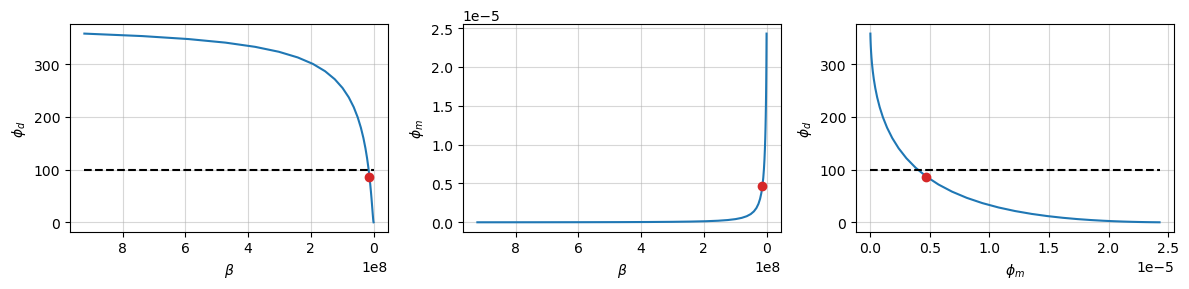

In [563]:
iteration = 19
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

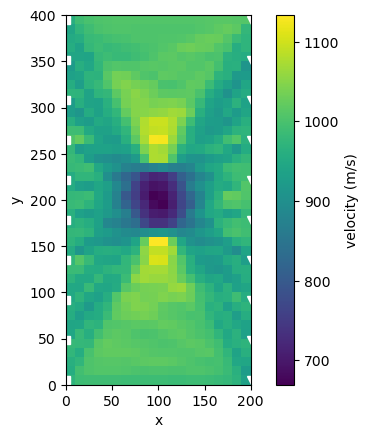

In [564]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

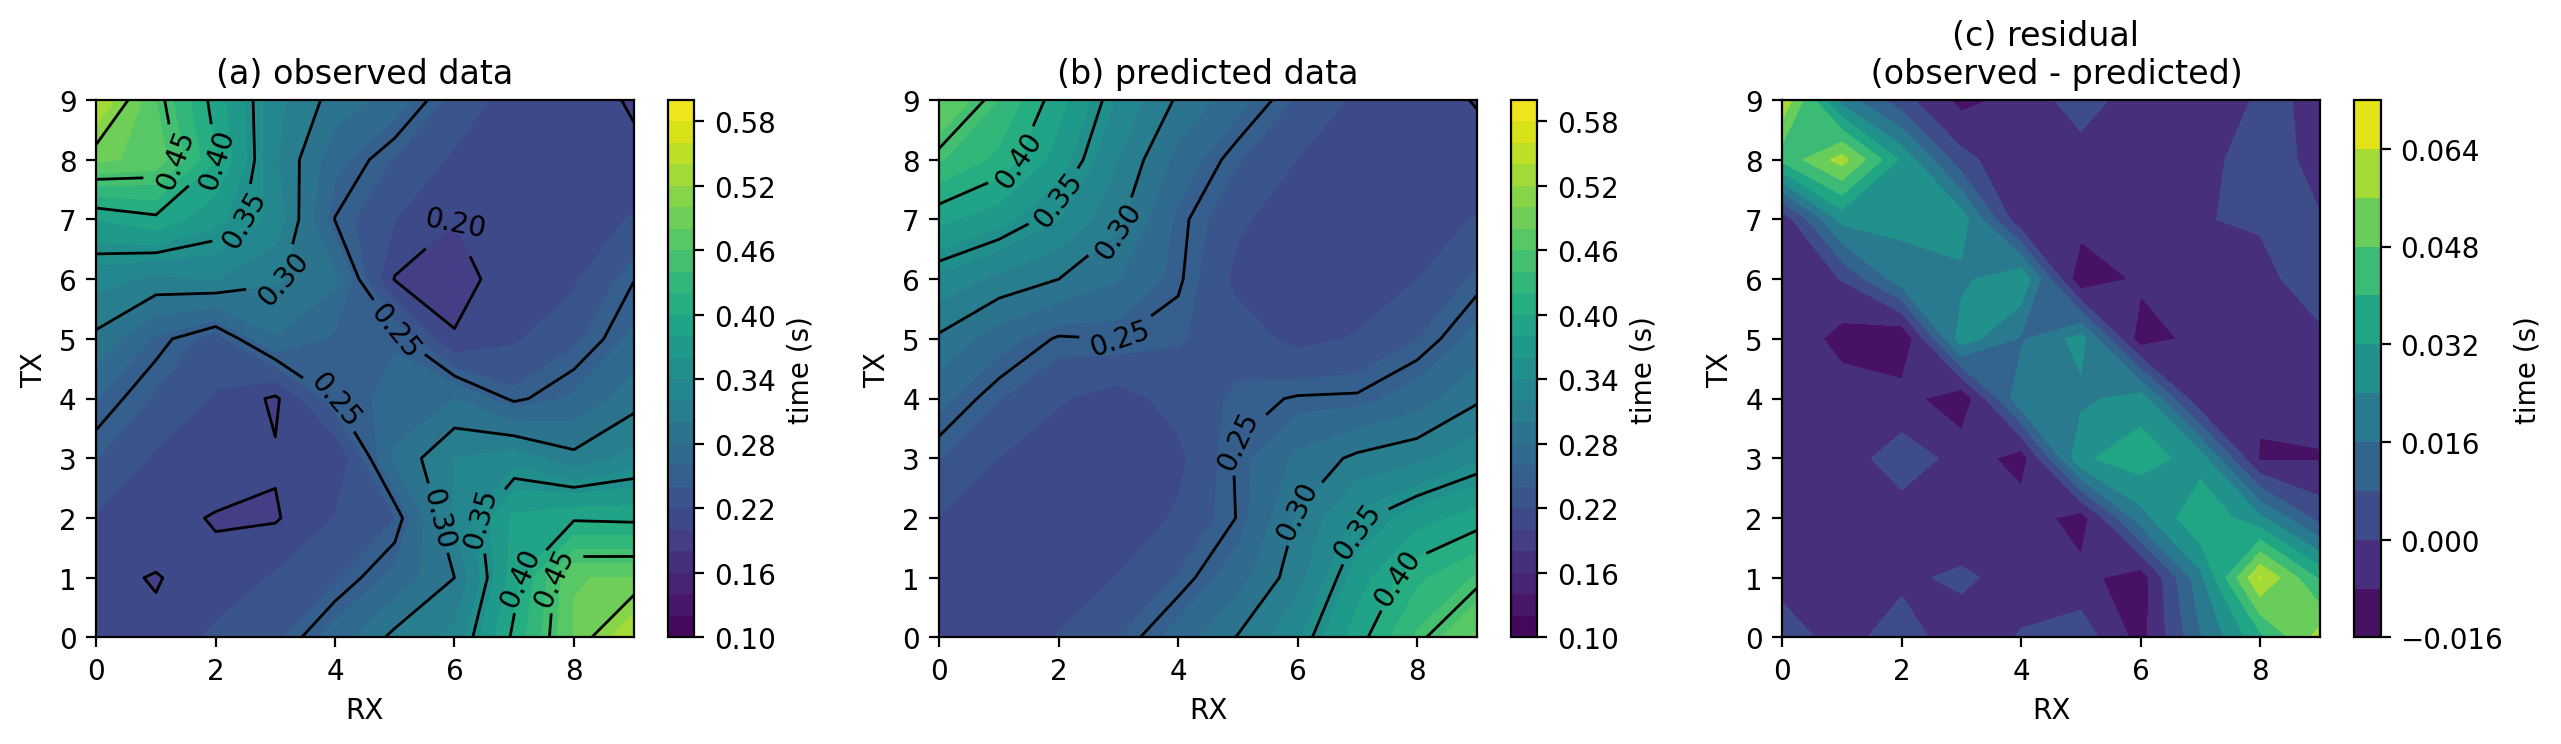

In [565]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

### Balanced alpha-values, underestimating the noise

In [566]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=50)

invprob = inverse_problem.BaseInvProblem(dmis_small_error, reg2, opt)

In [567]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [568]:
inv = inversion.BaseInversion(invprob, directives_list)

In [569]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.63e+11  1.51e+05  0.00e+00  1.51e+05    7.03e+07      0              
   1  3.70e+11  1.43e+05  8.64e-09  1.46e+05    1.35e+07      0              
   2  2.96e+11  1.41e+05  1.32e-08  1.45e+05    1.33e+07      0   Skip BFGS  
   3  2.37e+11  1.39e+05  2.00e-08  1.44e+05    1.31e+07      0   Skip BFGS  
   4  1.90e+11  1.36e+05  3.02e-08  1.42e+05    1.29e+07      0   Skip BFGS  
   5  1.52e+11  1.33e+05  4.53e-08  1.40e+05    1.27e+07      0   Skip BFGS  
   6  1.21e+11  1.29e+05  6.74e-08  1.38e+05    1.24e+07     

In [570]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

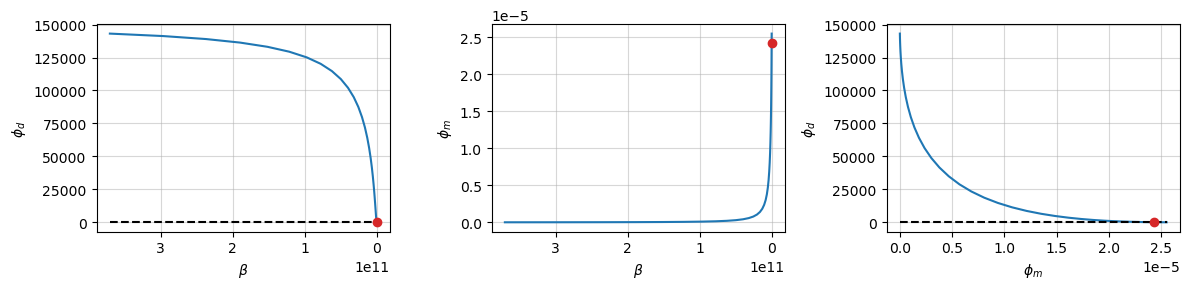

In [571]:
iteration = 39
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

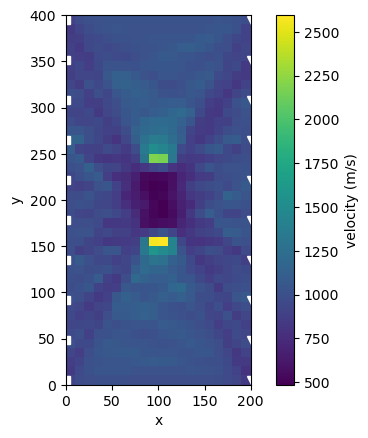

In [572]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

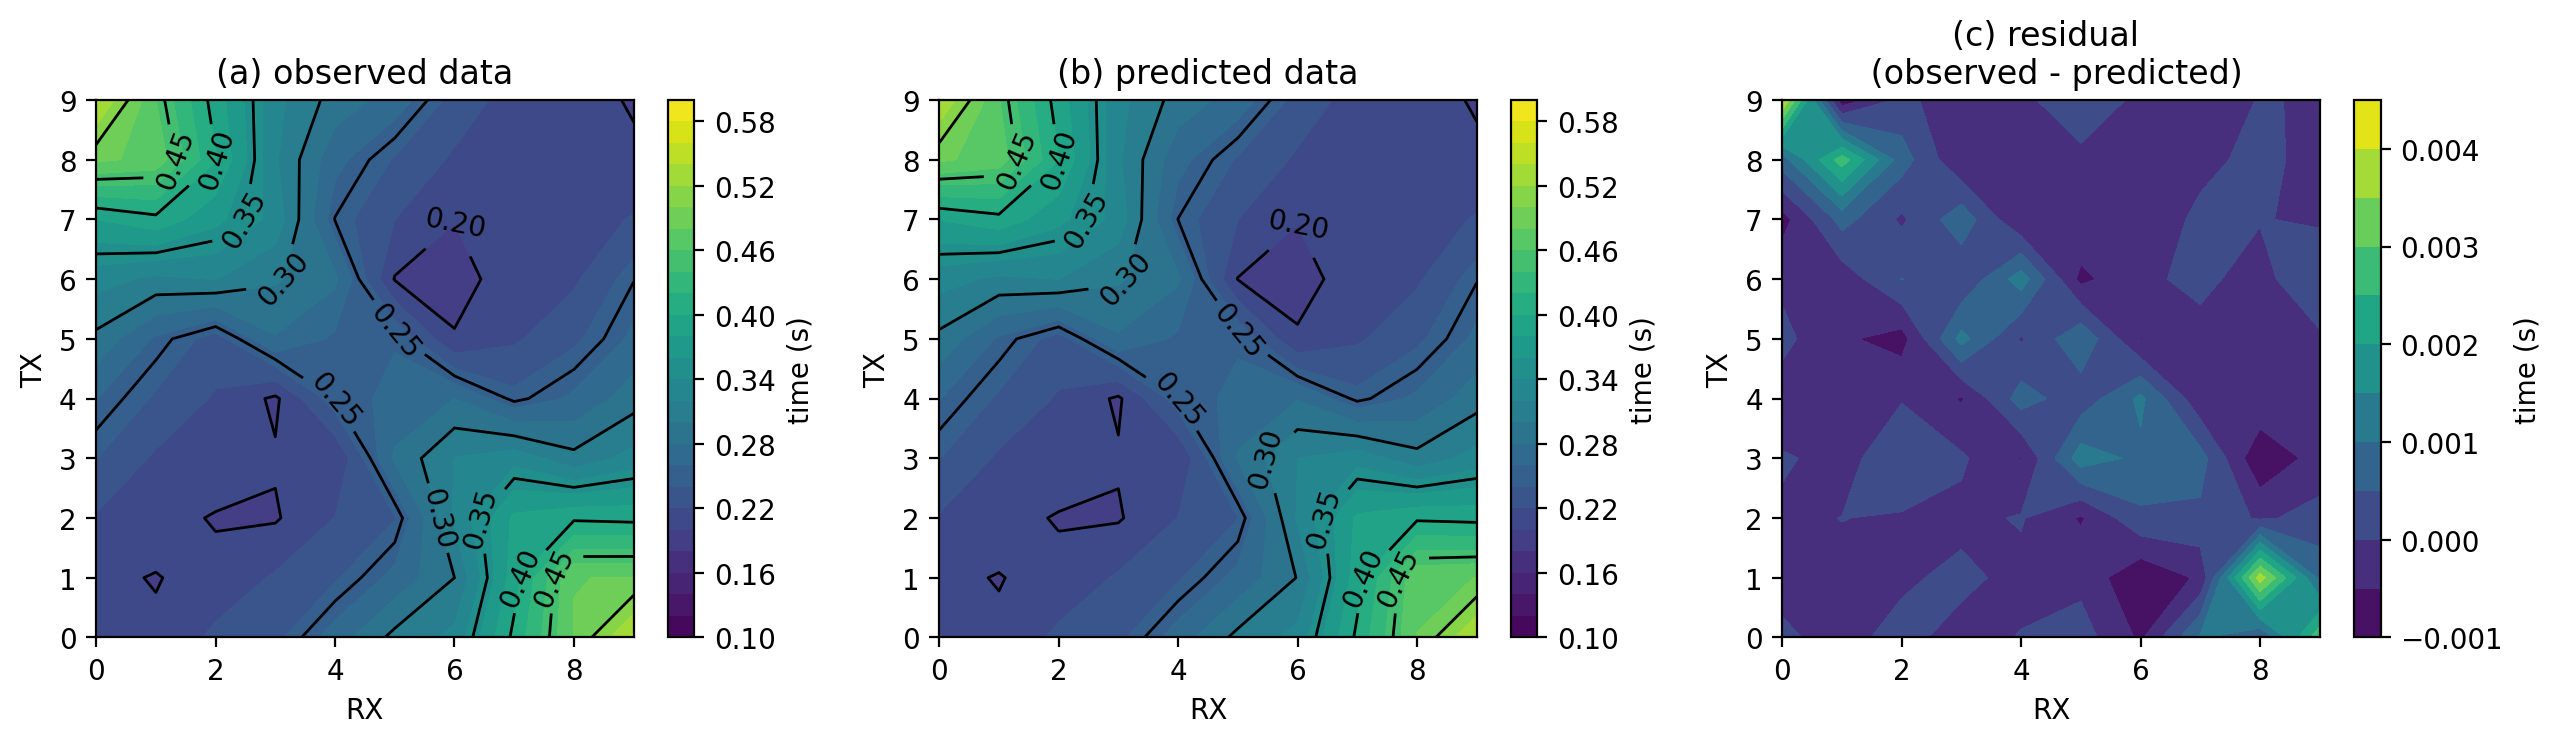

In [573]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

When using balanced alpha-values, while the predicted velocity is similar to the smoothest model approach, the geometry of the block is better reproduced for all cases (using correct or overestimating/underestimating the noise).  The reproduced features are also more pixelated.  



## Question 3(c)

When first encountering a new data set, as we know very little, starting with a smoothesst model seems to be a better option as it penalises structure with high gradients while showing general trends.  If more structure is expected or a reliable reference model can be inferred, then we can try to increase the alphas_s value such that more influence of the smallness term is allowed in the inversion.

## Question 3(d)

In [574]:
alpha_s2 = 1/mesh.h[0][0]**2
alpha_x2 = 1000
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg3 = alpha_s2 * reg_s + alpha_x2 * reg_x + alpha_y * reg_y

In [575]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis, reg3, opt)

In [576]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [577]:
inv = inversion.BaseInversion(invprob, directives_list)

In [578]:
m0 = background_slowness_model
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.77e+06  1.51e+03  0.00e+00  1.51e+03    7.03e+05      0              
   1  7.82e+06  6.71e+02  7.62e-06  7.31e+02    1.15e+05      0              
   2  6.25e+06  6.38e+02  1.07e-05  7.05e+02    5.37e+04      0   Skip BFGS  
   3  5.00e+06  6.18e+02  1.36e-05  6.85e+02    5.16e+04      0   Skip BFGS  
   4  4.00e+06  5.96e+02  1.74e-05  6.66e+02    4.99e+04      0   Skip BFGS  
   5  3.2

In [579]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

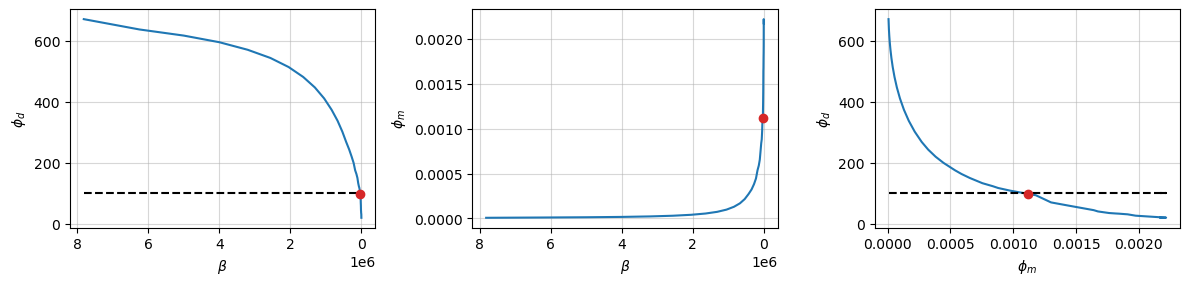

In [580]:
iteration = 25
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

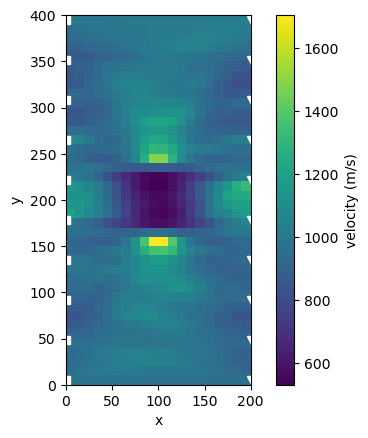

In [581]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

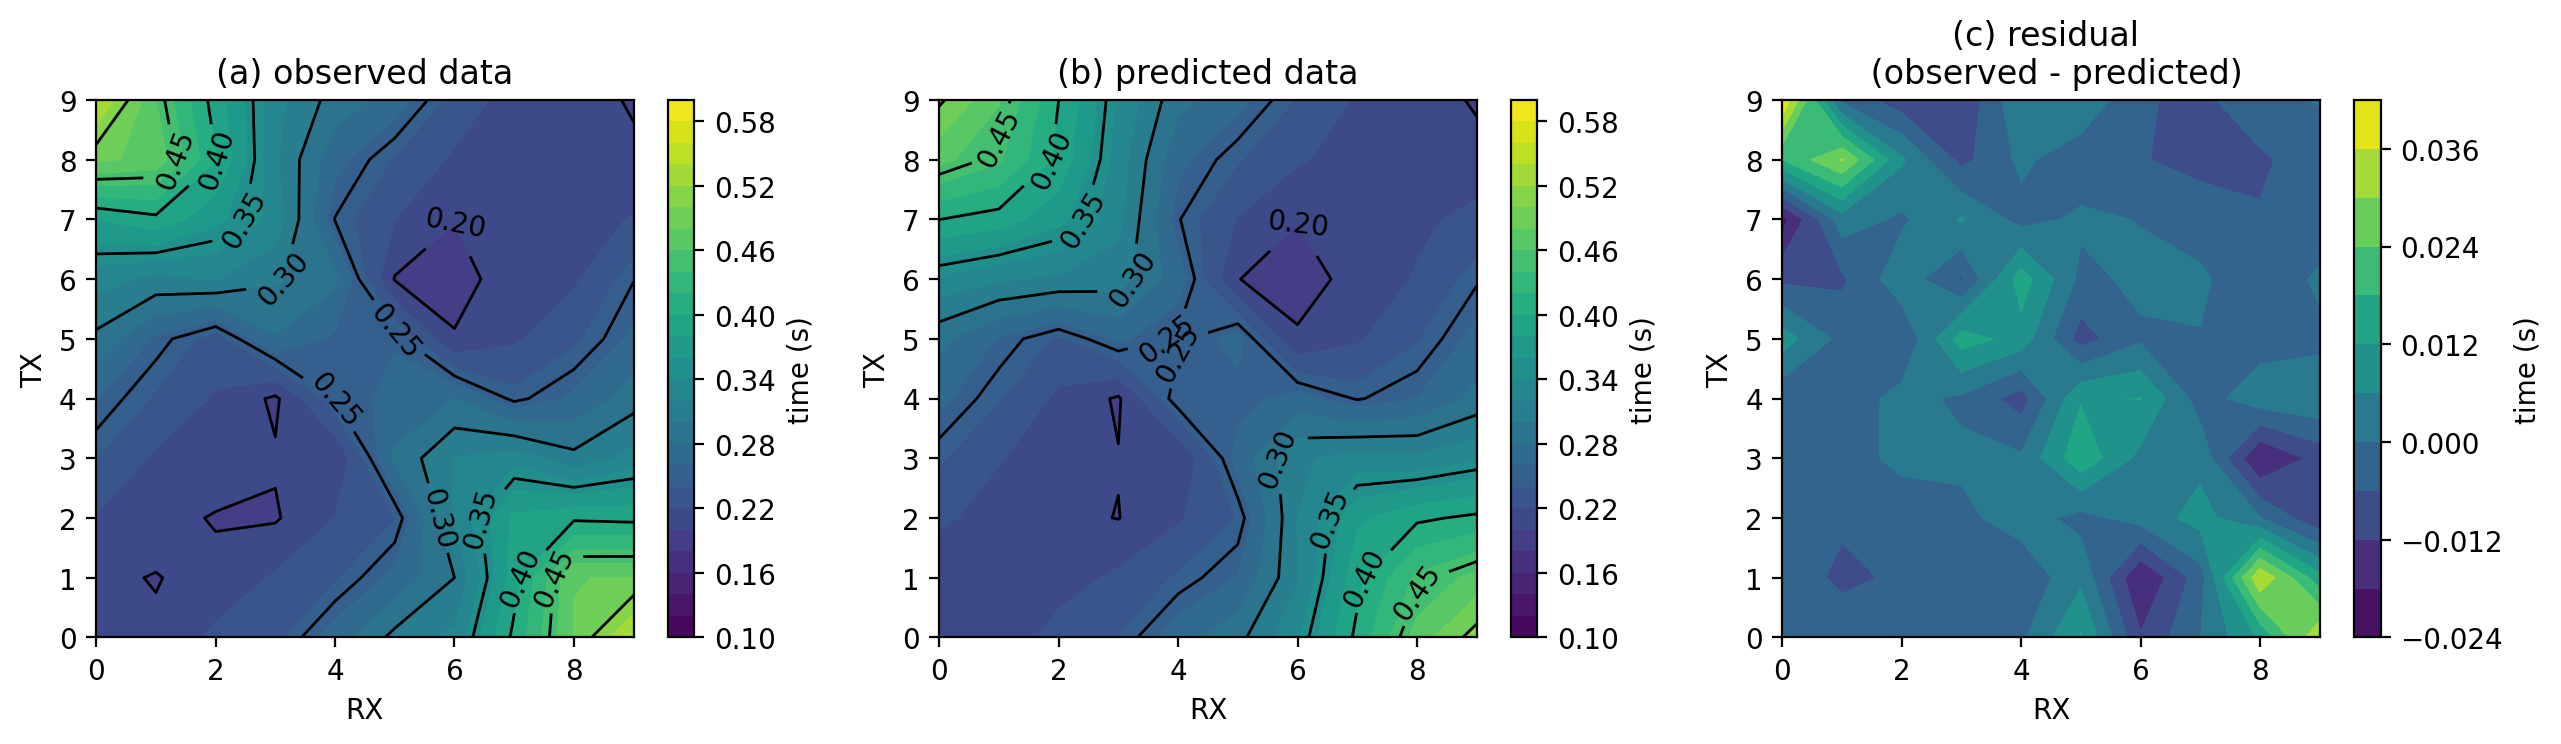

In [582]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

As more importance is put into the smoothness of the horizontal gradient, the features are reproduced as horizontal layers in the recovered model.

## Question 3(e)

In [583]:
alpha_s2 = 1/mesh.h[0][0]**2
alpha_x = 1
alpha_y2 = 1000

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg4 = alpha_s2 * reg_s + alpha_x * reg_x + alpha_y2 * reg_y

In [584]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis, reg4, opt)

In [585]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [586]:
inv = inversion.BaseInversion(invprob, directives_list)

In [587]:
m0 = background_slowness_model
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.75e+06  1.51e+03  0.00e+00  1.51e+03    7.03e+05      0              
   1  7.80e+06  9.27e+02  1.18e-05  1.02e+03    7.29e+04      0              
   2  6.24e+06  8.90e+02  1.60e-05  9.90e+02    7.04e+04      0   Skip BFGS  
   3  4.99e+06  8.51e+02  2.17e-05  9.59e+02    6.79e+04      0   Skip BFGS  
   4  3.99e+06  8.09e+02  2.93e-05  9.26e+02    6.53e+04      0   Skip BFGS  
   5  3.1

In [588]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

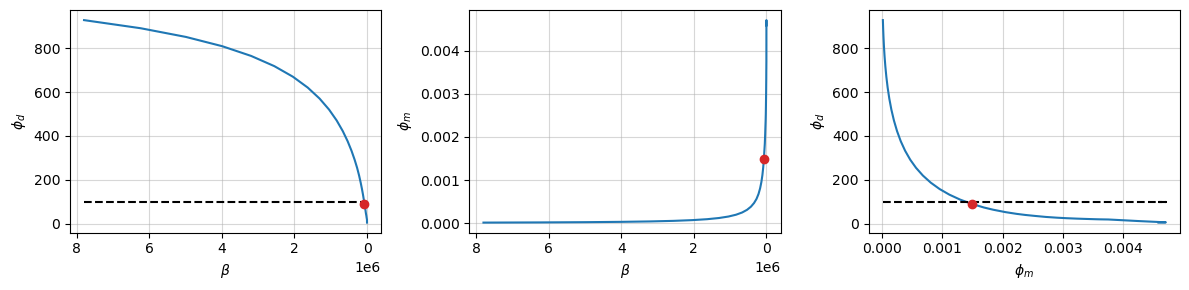

In [592]:
iteration = 21
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

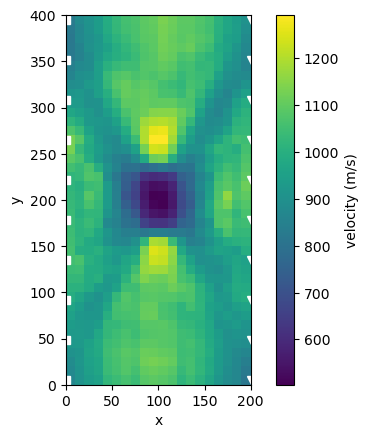

In [593]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

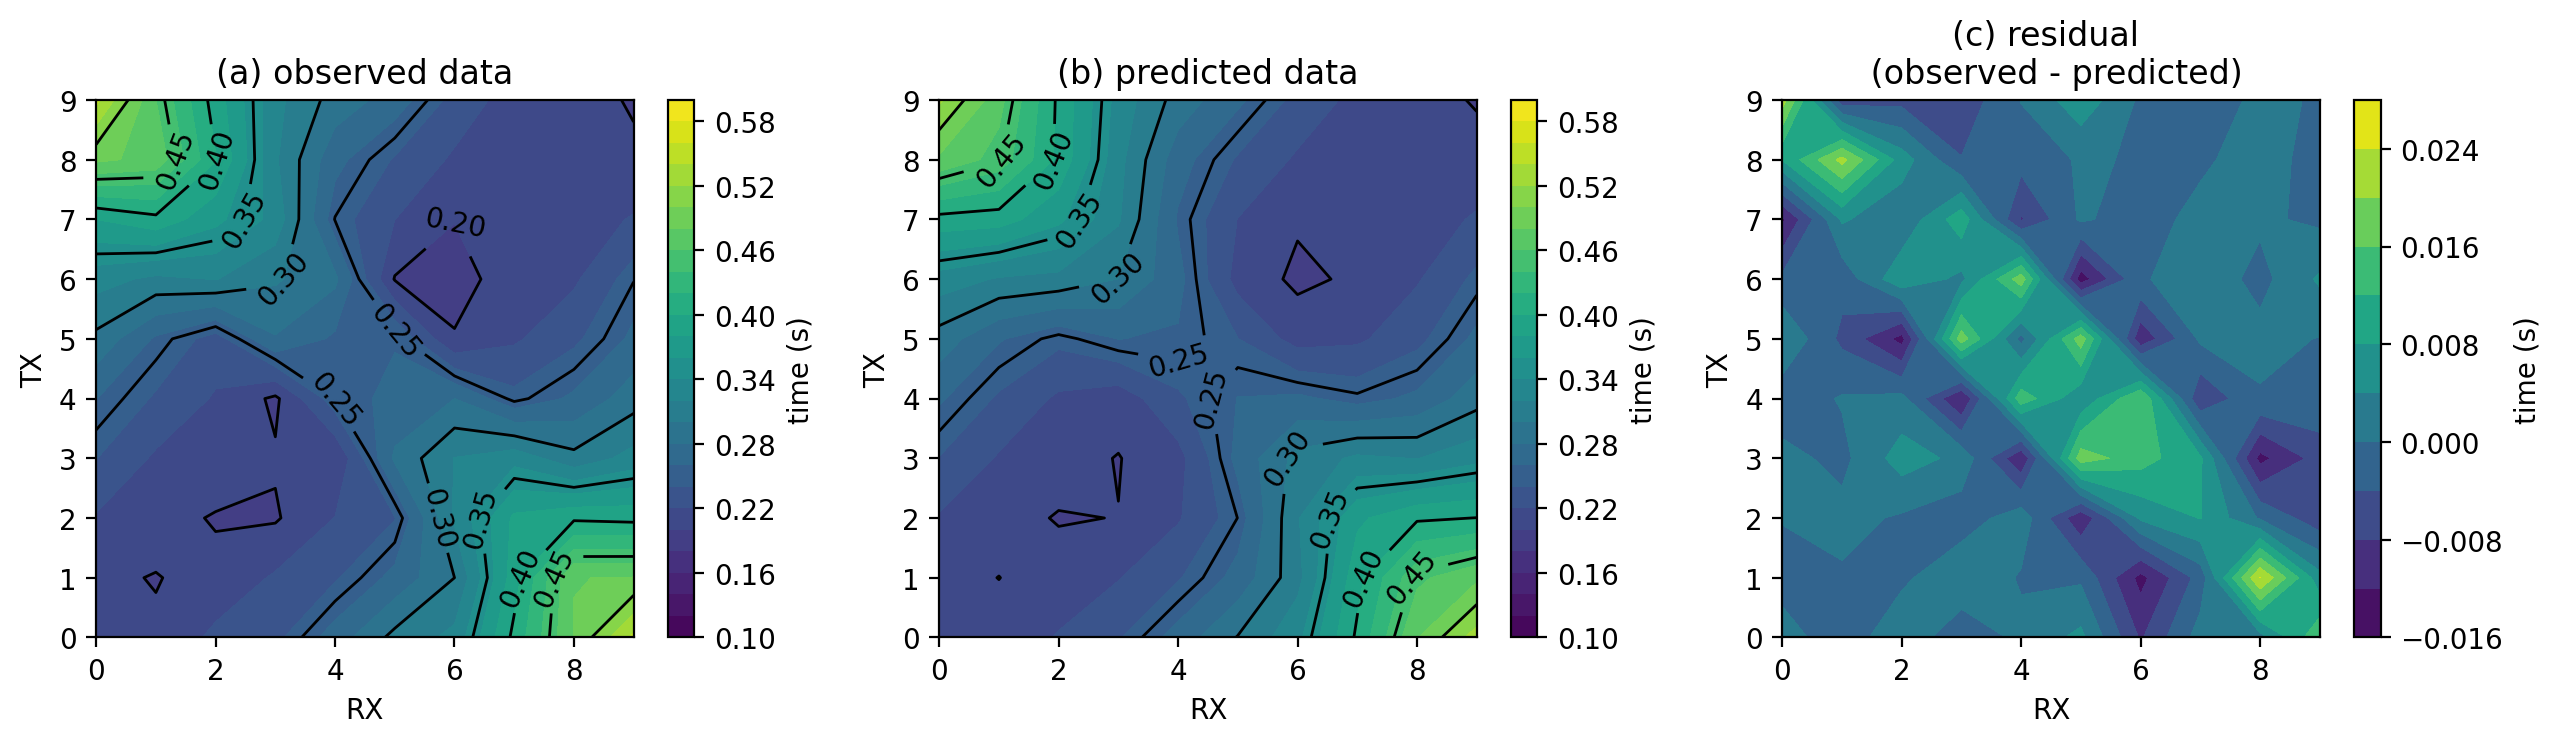

In [594]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion, dpred_i, data_for_inversion-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

As more importance is put into the smoothness of the vertical gradient, sharp vertical edges of the block can be seen in the recovered model.

## Question 4

In [596]:
relative_error=0.02
np.random.seed(7)

data_for_inversion_block_top = (
    clean_data_block_top + 
    np.random.randn(len(clean_data_block_top)) * relative_error * np.abs(clean_data_block_top)
)

In [597]:
data_object = data.Data(tomo_survey, dobs=data_for_inversion_block_top, relative_error=relative_error)

In [598]:
dmis = data_misfit.L2DataMisfit(data_object, simulation)

In [599]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [600]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [601]:
inv = inversion.BaseInversion(invprob, directives_list)

In [602]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.97e+09  6.57e+02  0.00e+00  6.57e+02    3.81e+05      0              
   1  4.77e+09  3.83e+02  1.17e-08  4.39e+02    4.47e+04      0              
   2  3.82e+09  3.67e+02  1.48e-08  4.23e+02    4.29e+04      0   Skip BFGS  
   3  3.05e+09  3.51e+02  1.86e-08  4.07e+02    4.12e+04      0   Skip BFGS  
   4  2.44e+09  3.35e+02  2.32e-08  3.92e+02    3.95e+04      0   Skip BFGS  
   5  1.95e+09  3.20e+02  2.88e-08  3.76e+02    3.79e+04      0   Skip BFGS  
   6  1.56e+09  3.04e+02  3.59e-08  3.60e+02    3.64e+04     

In [603]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

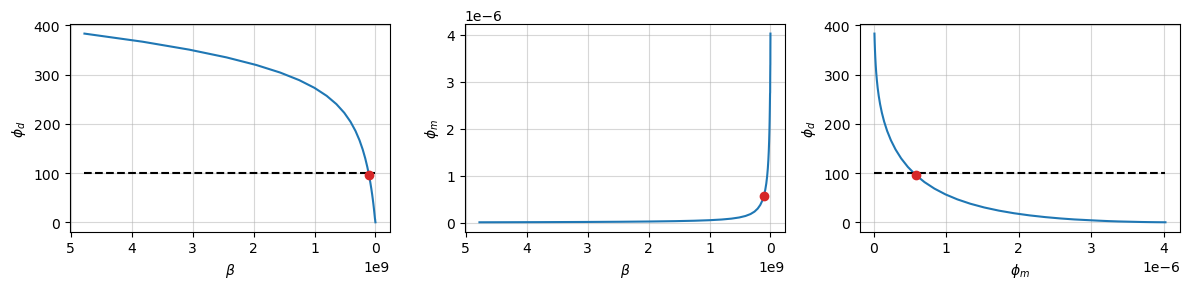

In [605]:
iteration = 17
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

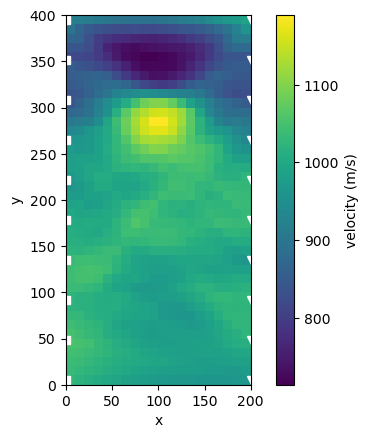

In [606]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

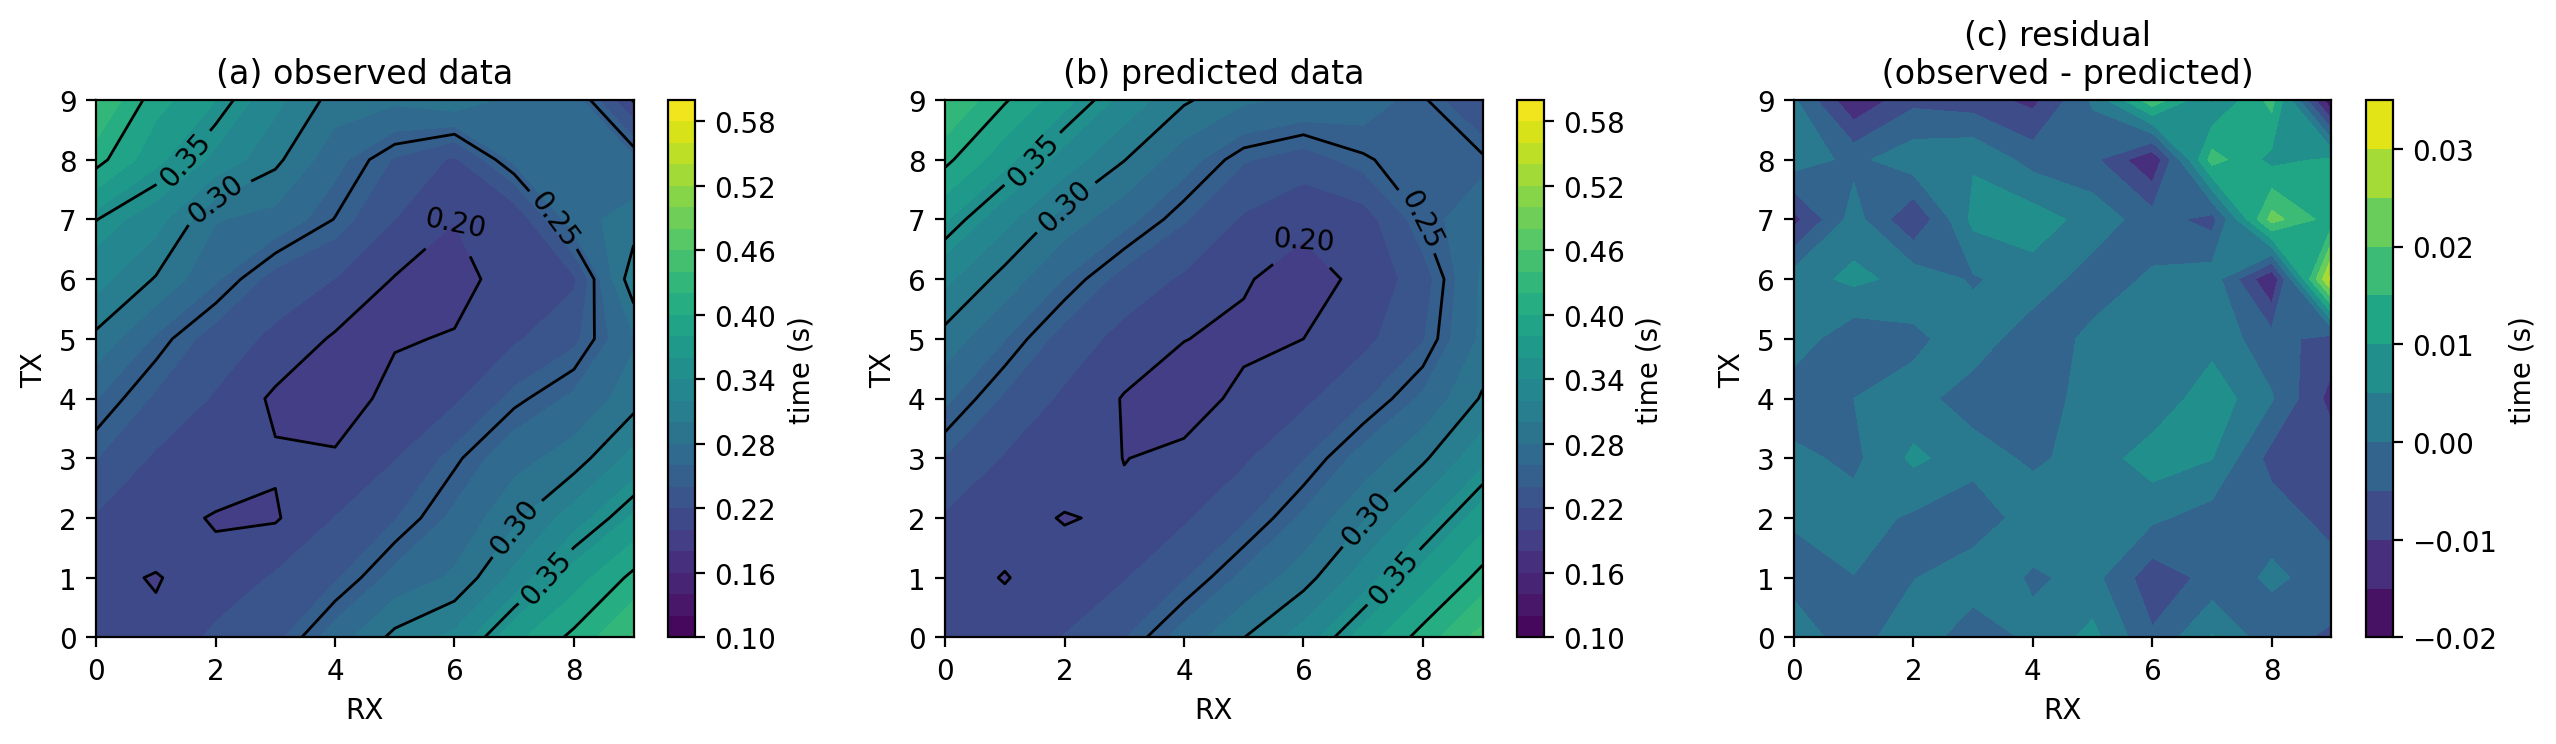

In [608]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion_block_top, dpred_i, data_for_inversion_block_top-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()

## Answer

The residuals between the predicted and observed data in both cases (block at the top vs in the middle) are similar in magnitude.

The velocity of the block (at the top) in the recovered model is less close to the true value.

The block (at the top) reproduced in the recovered model is in a shape of inverted triangle, which is due to the limited ray path travelling across the block.



## Question 5
### To explore how the survey design influences the results by reducing the number of sources/receivers from 10 to 6.

The number of sources/receivers are revised from 10 to 6. Subsequently the survey, simulation, data for simulation, data object and dmis are also updated.  Comparison using the smoothest model inversion is made. It can be seen that in the recovered model, the block is 
not as well-defined as the one reproduced with more sources/receivers.  The velocity is less close to the true value.  The residual in the data is also slightly higher compared with the one using more sources/receivers.

In [792]:
n_src_2 = 6
y_src_2 = np.linspace(dy/2, extent_y-dy/2, n_src_2)

source_locations_2 = np.c_[np.zeros_like(y_src_2), y_src_2]
receiver_locations_2 = np.c_[np.zeros_like(y_src_2) + mesh.nodes_x[-1], y_src_2]

<Axes: xlabel='x', ylabel='y'>

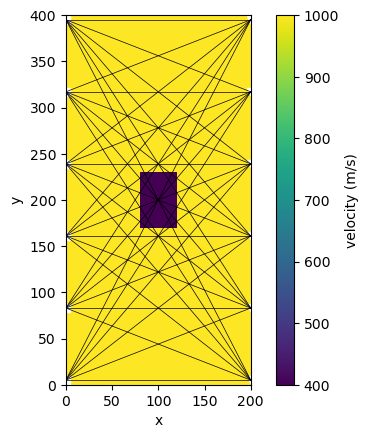

In [793]:
plot_model_survey(
    mesh, velocity_model, source_locations_2, receiver_locations_2,
    show_raypaths=True
)

In [794]:
# Simulation

rx2 = survey.BaseRx(receiver_locations_2)


source_list_2 = []

for i in range(y_src_2.size):
    source_list_2.append(
        survey.BaseSrc(
            location=source_locations_2[i, :], receiver_list=[rx2]
        )
    )

In [795]:
tomo_survey_2 = seismic.straight_ray_tomography.Survey(source_list_2)


In [796]:
simulation_2 = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey_2,
    slownessMap=maps.IdentityMap(mesh),
)

In [797]:
clean_data_2 = simulation_2.dpred(true_slowness_model)

relative_error=0.02
np.random.seed(7)

data_for_inversion_2 = (
    clean_data_2 + 
    np.random.randn(len(clean_data_2)) * relative_error * np.abs(clean_data_2)
)

In [798]:
data_object_2 = data.Data(tomo_survey_2, dobs=data_for_inversion_2, relative_error=relative_error)

In [799]:
dmis_2 = data_misfit.L2DataMisfit(data_object_2, simulation_2)

In [800]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=40)

invprob = inverse_problem.BaseInvProblem(dmis_2, reg, opt)

In [801]:
chifact=0.1
beta0_ratio=1e2
coolingFactor=1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)


directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [802]:
inv = inversion.BaseInversion(invprob, directives_list)

In [803]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.53e+09  4.11e+02  0.00e+00  4.11e+02    2.54e+05      0              
   1  2.02e+09  2.64e+02  9.82e-09  2.84e+02    2.92e+04      0              
   2  1.62e+09  2.56e+02  1.34e-08  2.78e+02    2.85e+04      0   Skip BFGS  
   3  1.30e+09  2.48e+02  1.81e-08  2.71e+02    2.79e+04      0   Skip BFGS  
   4  1.04e+09  2.38e+02  2.45e-08  2.64e+02    2.72e+04      0   Skip BFGS  
   5  8.29e+08  2.28e+02  3.32e-08  2.56e+02    2.64e+04      0   Skip BFGS  
   6  6.63e+08  2.18e+02  4.49e-08  2.47e+02    2.56e+04     

In [804]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

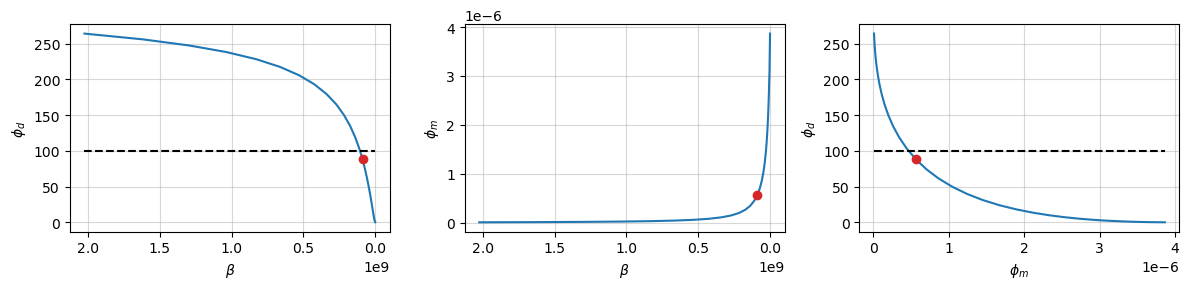

In [806]:
iteration = 14
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

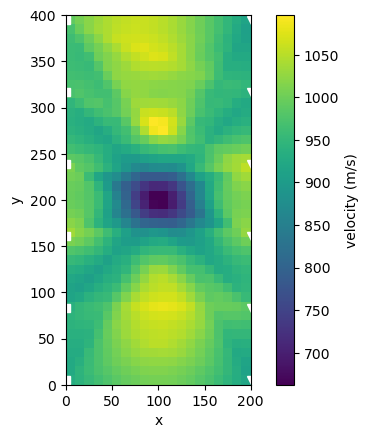

In [807]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations_2, receiver_locations_2,
    show_raypaths=False,
)

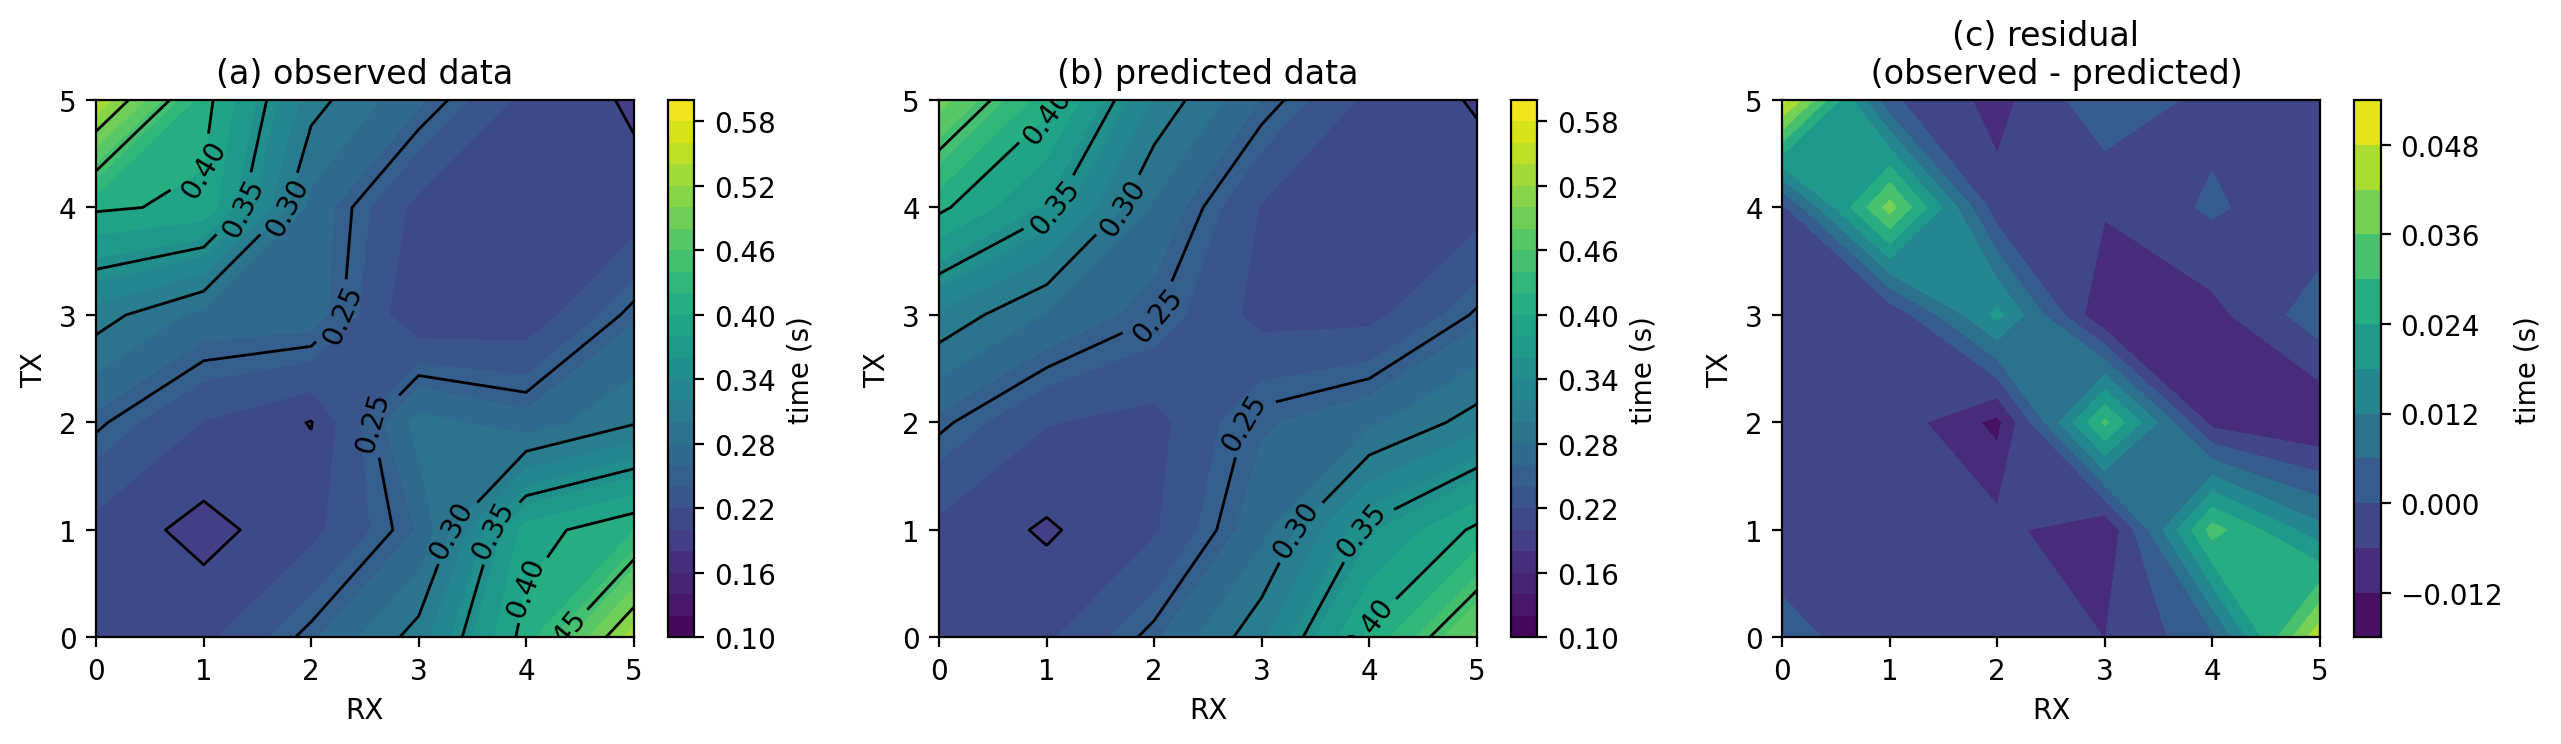

In [808]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation_2.dpred(models[iteration])

for i, dplot in enumerate([data_for_inversion_2, dpred_i, data_for_inversion_2-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src_2, n_src_2, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src_2, n_src_2, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src_2, n_src_2, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()